**¿Es posible estimar el caudal y corte de agua de un pozo nuevo para el campo?**

El objetivo del presente trabajo es estimar el caudal de un pozo nuevo en el campo de explotación a partir de datos históricos de pozos ya existentes. Para llevarlo a cabo se empleó un dataset llamado Oil Field con datos y mediciones del año 2019.

In [1]:
#Importaciones
#fundamentales
import pandas as pd
import numpy as np

# #graficos
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns 

# #modelado
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as sm
from sklearn import datasets
from sklearn import tree
from dtreeviz.trees import dtreeviz
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, neighbors


#Algoritms to Model Cluster
from sklearn.tree import DecisionTreeClassifier #estoy importando el algoritmo de Arboles de decision
from sklearn.linear_model import LogisticRegression #estoy importando el algoritmo de Regresion Logistica
import xgboost as xgb
import lightgbm as ltb
from sklearn.neighbors import KNeighborsClassifier #estoy importando el algoritmo de KNN
from sklearn.cluster import KMeans

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

#Algoritms to Model Interpolation
from sklearn.linear_model import LinearRegression

# #Metrics
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import silhouette_score,silhouette_samples

#Export Model
import pickle

# #Config 
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# carga de Dataset y analisis del mismo 
df = pd.read_csv('oilField.csv')


In [2]:
#Estructura del dataset
print(df.info())

df.Fecha=pd.to_datetime(df.Fecha)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4494 entries, 0 to 4493
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   POZO            4494 non-null   object 
 1   XCOORD          4494 non-null   int64  
 2   YCOORD          4494 non-null   int64  
 3   Prof            4494 non-null   int64  
 4   Fecha           4494 non-null   object 
 5   runlife         4494 non-null   int64  
 6   ciclo           4494 non-null   int64  
 7   Dpiston         4494 non-null   float64
 8   Lon_Superficie  4494 non-null   int64  
 9   SPM             4494 non-null   int64  
 10  RGP             4494 non-null   float64
 11  AYS             4494 non-null   float64
 12  Elasticity      4494 non-null   float64
 13  SP              4494 non-null   float64
 14  Fillage         4494 non-null   float64
 15  BBPD            4494 non-null   float64
 16  BNPD            4494 non-null   float64
dtypes: float64(8), int64(7), object(2

In [3]:
# Analisis de nulos
print(df.isna().sum())

POZO              0
XCOORD            0
YCOORD            0
Prof              0
Fecha             0
runlife           0
ciclo             0
Dpiston           0
Lon_Superficie    0
SPM               0
RGP               0
AYS               0
Elasticity        0
SP                0
Fillage           0
BBPD              0
BNPD              0
dtype: int64


En los analisis anteriores podemos apreciar que en el dataset no existen elementos nulos, y solo es necesario convertir el campo "Fecha" por eso lo convertimos a tipo de dato fecha. 

In [4]:
#Analisis de duplicados
s = df.duplicated(keep=False)

print(s.to_frame().reset_index().groupby([0])[['index']].sum())

          index
0              
False  10095771


Con base en el análisis anterior, se observa que no existen campos duplicados.

In [5]:
#Outliners
df['MaxTeorical'] = (df['Dpiston'].astype(float) * df['Dpiston'].astype(float) * df['SPM'].astype(float)*0.1166*115).astype(float)
df['isBBPDOverMaxTeorical'] = pd.Series(dtype='string')


df.loc[df['MaxTeorical']>=df['BBPD'].astype(int),'isBBPDOverMaxTeorical'] = df.loc[df['MaxTeorical']>=df['BBPD'].astype(int)].fillna('ok')
df.loc[df['MaxTeorical']<df['BBPD'].astype(int),'isBBPDOverMaxTeorical'] = df.loc[df['MaxTeorical']<df['BBPD'].astype(int)].fillna('outliner')

print(df.groupby(['isBBPDOverMaxTeorical'])[['POZO']].count())


                       POZO
isBBPDOverMaxTeorical      
ok                     4494


En en análisis anterior comprobamos que no hay outliners teóricos.

**Problema comercial.**: la tarea general es intentar llegar a un primer modelo capaz de predecir variables relacionadas al caudal de un pozo, basado en su geolocalización. De esta forma sería posible hacer sensibilidades en función a la ubicación de latitud y longitud del campo.

**Adquisición de data**: el dataset de entrada es un cúmulo de las medidas de los 99 pozos del campo para el año 2019. A cada pozo se le toman de 3 a 5 medidas mensuales con un promedio de 3.75 medidas aproximadamente. Es importante recalcar que estas variables son de mayor calidad en el campo pues las mismas son continuamente validadas al ser directamente vinculadas a los ingresos.

**Preguntas Generales**:  en líneas generales el cliente presenta las siguientes preguntas: 

1).- ¿Existe alguna sectorización del campo y de ser así en base a que valores y cuáles serían su ubicación geográfica?

2).- ¿Qué tanto afecta la arena de producción al caudal esperado para los pozos?

3).-¿Qué efectos tiene los ciclos de inyección en los pozos y hasta cuántos ciclos es recomendable inyectar?

4).-¿Qué relación existe entre las variables operativas y qué tan optimizado está el campo?

5).-¿Es homogéneo el comportamiento de los pozos a lo largo del campo o existen grupo basados a su tasa de producción, qué tan confiable sería un plan de explotación en el tiempo?

6).-¿Es posible clasificar un pozo nuevo como alto, medio o bajo productor y que método es el que resulta más apropiado para modelarlo?

7).-¿Es posible clasificar un pozo nuevo como alto, medio o bajo corte de agua y que método es el que resulta más apropiado para modelarlo?

8).-¿Es posible predecir la tasa de producción bruta de un pozo nuevo y que método resulta más aporpiado?

9).-¿Es posible predecir la tasa de agua de un pozo nuevo y que método resulta más aporpiado?

In [6]:
#Campos calculados y agrupaciones


df['RGP'] = df['RGP'].astype(int) 
df['AYS'] = df['AYS'].astype(int) 
df['Elasticity'] = (df['Elasticity'] * 100).astype(int)
df['SP'] = (df['SP'] * 100).astype(int)
df['Fillage'] = (df['Fillage'] * 100).astype(int)

df['sand'] = pd.Series(dtype='string')
df['problem'] = pd.Series(dtype='string')
df['bnpd_group'] = pd.Series(dtype='string')
df['bbpd_group'] = pd.Series(dtype='string')

df.loc[df['Prof']<7200,'sand'] = df.loc[df['Prof']<7200].fillna('A')
df.loc[df['Prof']>=7200,'sand'] = df.loc[df['Prof']>=7200].fillna('B')

df.loc[df['XCOORD']<160,'problem'] = df.loc[df['XCOORD']<160].fillna('Watter')
df.loc[df['XCOORD']>=160,'problem'] = df.loc[df['XCOORD']>=160].fillna('Gas')


df.loc[(df['BNPD']>=0)&(df['BNPD']<=100),'bnpd_group'] = df.loc[(df['BNPD']>=0)&(df['BNPD']<=100)].fillna('low')
df.loc[(df['BNPD']>=100)&(df['BNPD']<=200),'bnpd_group'] = df.loc[(df['BNPD']>=100)&(df['BNPD']<=200)].fillna('mid')
df.loc[df['BNPD']>=200,'bnpd_group'] = df.loc[df['BNPD']>=200].fillna('high')

df.loc[(df['BBPD']>=0)&(df['BBPD']<=100),'bbpd_group'] = df.loc[(df['BBPD']>=0)&(df['BBPD']<=100)].fillna('low')
df.loc[(df['BBPD']>=100)&(df['BBPD']<=200),'bbpd_group'] = df.loc[(df['BBPD']>=100)&(df['BBPD']<=200)].fillna('mid')
df.loc[df['BBPD']>=200,'bbpd_group'] = df.loc[df['BBPD']>=200].fillna('high')

df["BWPD"] = df["BBPD"] - df["BNPD"]



print(df.columns)


params = {
    'XCOORD':'mean',
    'YCOORD':'mean',
    'Prof':'mean',
    'runlife':'mean',
    'ciclo':'mean',
    'Lon_Superficie':'mean',
    'Dpiston':'mean',
    'SP':'mean',
    'SPM':'mean',
    'RGP':'mean',
    'AYS':'mean',
    'Elasticity':'mean',
    'Fillage':'mean',
    'BBPD':'mean',
    'BNPD':'mean',
    'BWPD':'mean'
}

df_maestra = df.groupby(['POZO','sand','problem'])[['XCOORD','YCOORD',"Prof",'runlife','ciclo','Lon_Superficie','Dpiston','SP','SPM','RGP','AYS','Elasticity','Fillage','BBPD','BNPD','BWPD']].agg(params).reset_index()

print(df_maestra.columns)

Index(['POZO', 'XCOORD', 'YCOORD', 'Prof', 'Fecha', 'runlife', 'ciclo',
       'Dpiston', 'Lon_Superficie', 'SPM', 'RGP', 'AYS', 'Elasticity', 'SP',
       'Fillage', 'BBPD', 'BNPD', 'MaxTeorical', 'isBBPDOverMaxTeorical',
       'sand', 'problem', 'bnpd_group', 'bbpd_group', 'BWPD'],
      dtype='object')
Index(['POZO', 'sand', 'problem', 'XCOORD', 'YCOORD', 'Prof', 'runlife',
       'ciclo', 'Lon_Superficie', 'Dpiston', 'SP', 'SPM', 'RGP', 'AYS',
       'Elasticity', 'Fillage', 'BBPD', 'BNPD', 'BWPD'],
      dtype='object')


**Overview de la data**: las columnas del dataset son: 

•	POZO: nombre del pozo.

•	XCOORD : coordenada de latitud llevado a una referencia relativa.

•	YCOORD: coordenada de longitud llevado a una referencia relativa.

•	Prof: profundidad de la arena productora del pozo.

•	Fecha: fecha de la medida.

•	Runlife: tiempo de vida de la bomba de subsuelo.

•	Ciclo: ciclo de inyección del pozo.

•	Dpiston: diámetro del pistón de la bomba de subsuelo.

•	Lon_Superficie: longitud de la carrera de superficie de los pozos.

•	SPM: velocidad de ciclos por minutos del equipo de superficie.

•	RGP: relación de la cantidad de gas y petróleo producido en conjuntos. 

•	AYS: porcentaje de agua producida.

•	Elasticity: porcentaje de transmisibilidad de la carrera de superficie a fondo.

•	SP: longitud efectiva de la carrera del pistón en la bomba de subsuelo.

•	Fillage: llenado efectivo de líquido en la bomba de subsuelo.

•	BBPD: barriles líquidos producidos por cada pozo contando el petróleo y agua.

•	BNPD: barriles líquidos producidos por cada pozo solo considerando el petróleo.

•	BBWP: barriles líquidos que no son petróleo (normalmente agua).

**======================================================Data Scaning===================================================**

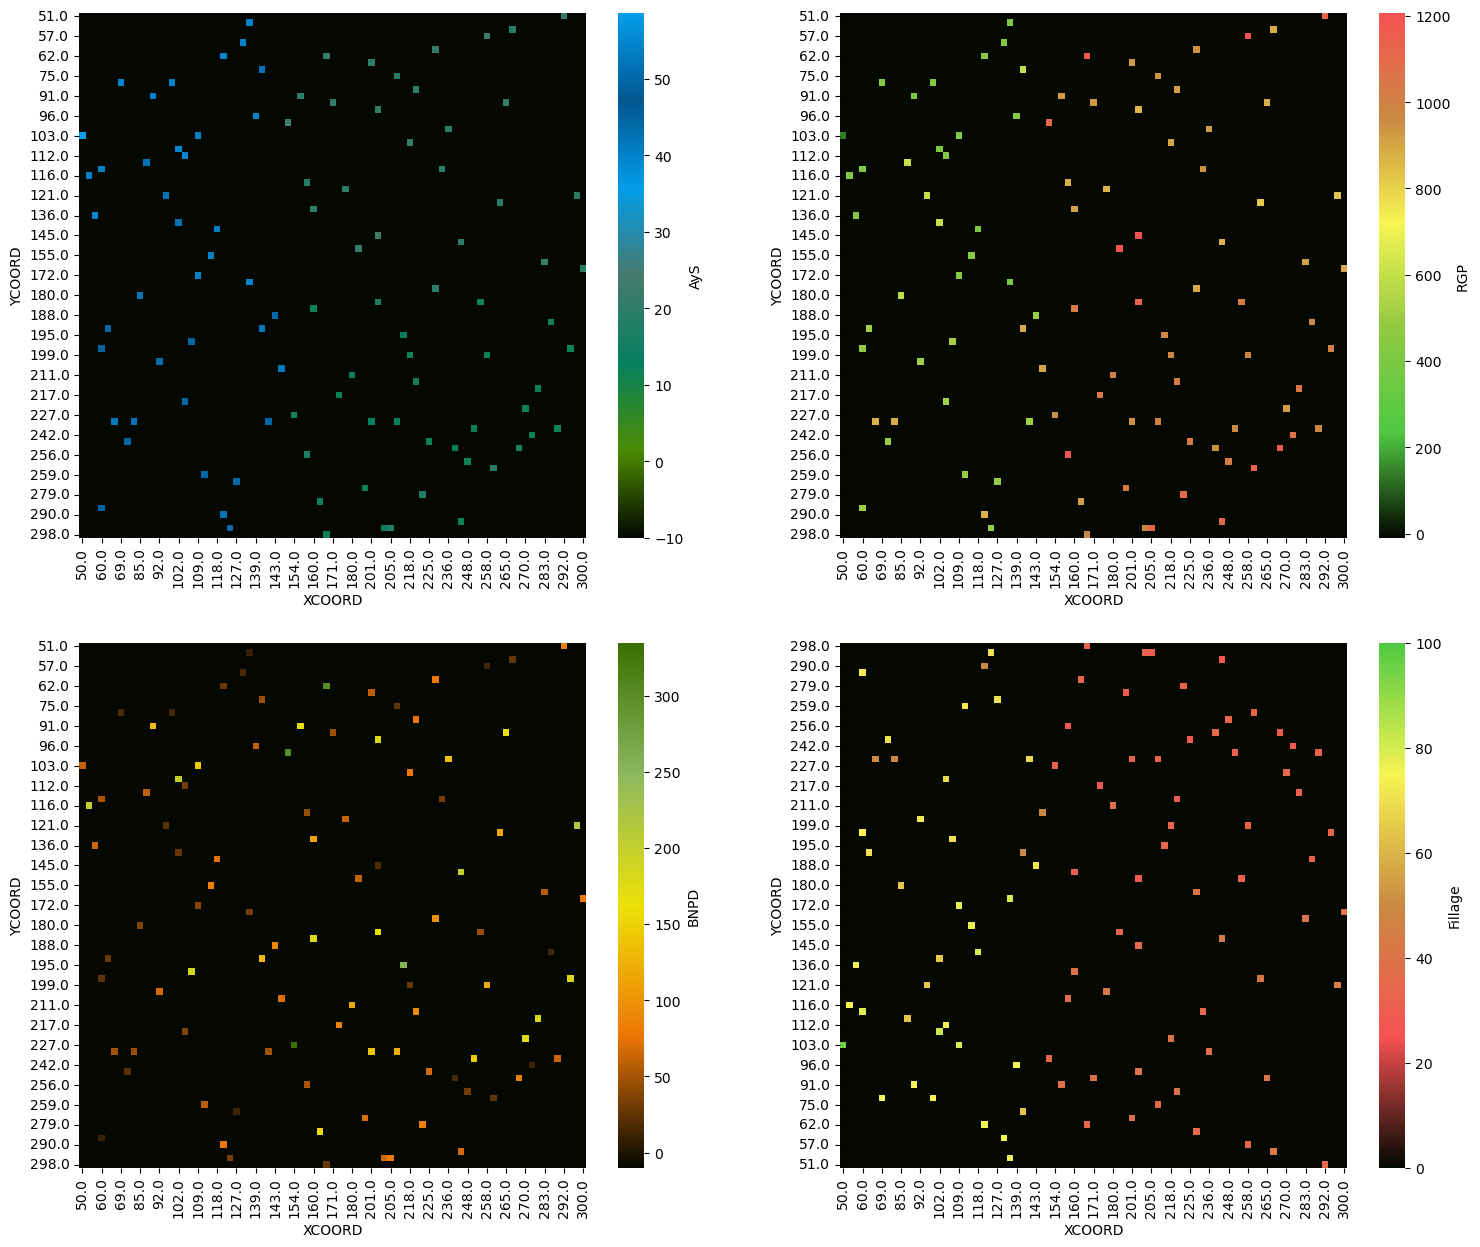

In [7]:
#Field Map
df_ays_pivot = pd.pivot_table(df_maestra,values='AYS',columns='XCOORD',index=['YCOORD'], aggfunc=np.mean).fillna(-10)
df_rgp_pivot = pd.pivot_table(df_maestra,values='RGP',columns='XCOORD',index=['YCOORD'], aggfunc=np.mean).fillna(-10)
df_bnpd_pivot = pd.pivot_table(df_maestra,values='BNPD',columns='XCOORD',index=['YCOORD'], aggfunc=np.mean).fillna(-10)
df_fillage_pivot = pd.pivot_table(df_maestra,values='Fillage',columns='XCOORD',index=['YCOORD'], aggfunc=np.mean).fillna(-10)

f, axes = plt.subplots(2,2,figsize=(18, 15))

colorsAys = ["#040800","#4c8c03","#05805f","#477a6d","#029deb","#01568f","#029deb"]
colorsRgp = ["#040800","#50c942","#91c942","#f7f552","#c98a42","#f75252"]

colorsBNPD = ["#040800","#ed7607","#ede107","#8cb85f","#397001"]

colorsFillage = ["#040800","#f75252","#c98a42","#f7f552","#50c942"]

cmapAys = mpl.colors.LinearSegmentedColormap.from_list("",colorsAys)
cmapRgp = mpl.colors.LinearSegmentedColormap.from_list("",colorsRgp)
cmapBnpd = mpl.colors.LinearSegmentedColormap.from_list("",colorsBNPD)
cmapFillage = mpl.colors.LinearSegmentedColormap.from_list("",colorsFillage)

aj = sns.heatmap(ax=axes[0,0], data=df_ays_pivot ,cmap=cmapAys , cbar_kws={'label' :'AyS'})
aj = sns.heatmap(ax=axes[0,1], data=df_rgp_pivot ,cmap=cmapRgp, cbar_kws={'label' :'RGP'})
aj = sns.heatmap(ax=axes[1,0], data=df_bnpd_pivot ,cmap=cmapBnpd, cbar_kws={'label' :'BNPD'})
aj = sns.heatmap(ax=axes[1,1], data=df_fillage_pivot ,cmap=cmapFillage, vmin=0, vmax=100, cbar_kws={'label' :'Fillage'})
aj.invert_yaxis()

1).- ¿Existe alguna sectorización del campo y de ser así en base a qué valores y cuáles serían su ubicación geográfica?

Con base en la comparación anterior, se observa que existe claramente una separación en 2 macro cuadrantes, dominados por varias condiciones, una de las  cuales es la XCOORD, partiendo de 0-160 predominado por la producción de Agua y otro con XCOORD 160-300 afectado por la producción de gas. Aunque en el gráfico [1,0] donde vemos distribución espacial de producción de crudo no se observa una muy clara distribución categórica.

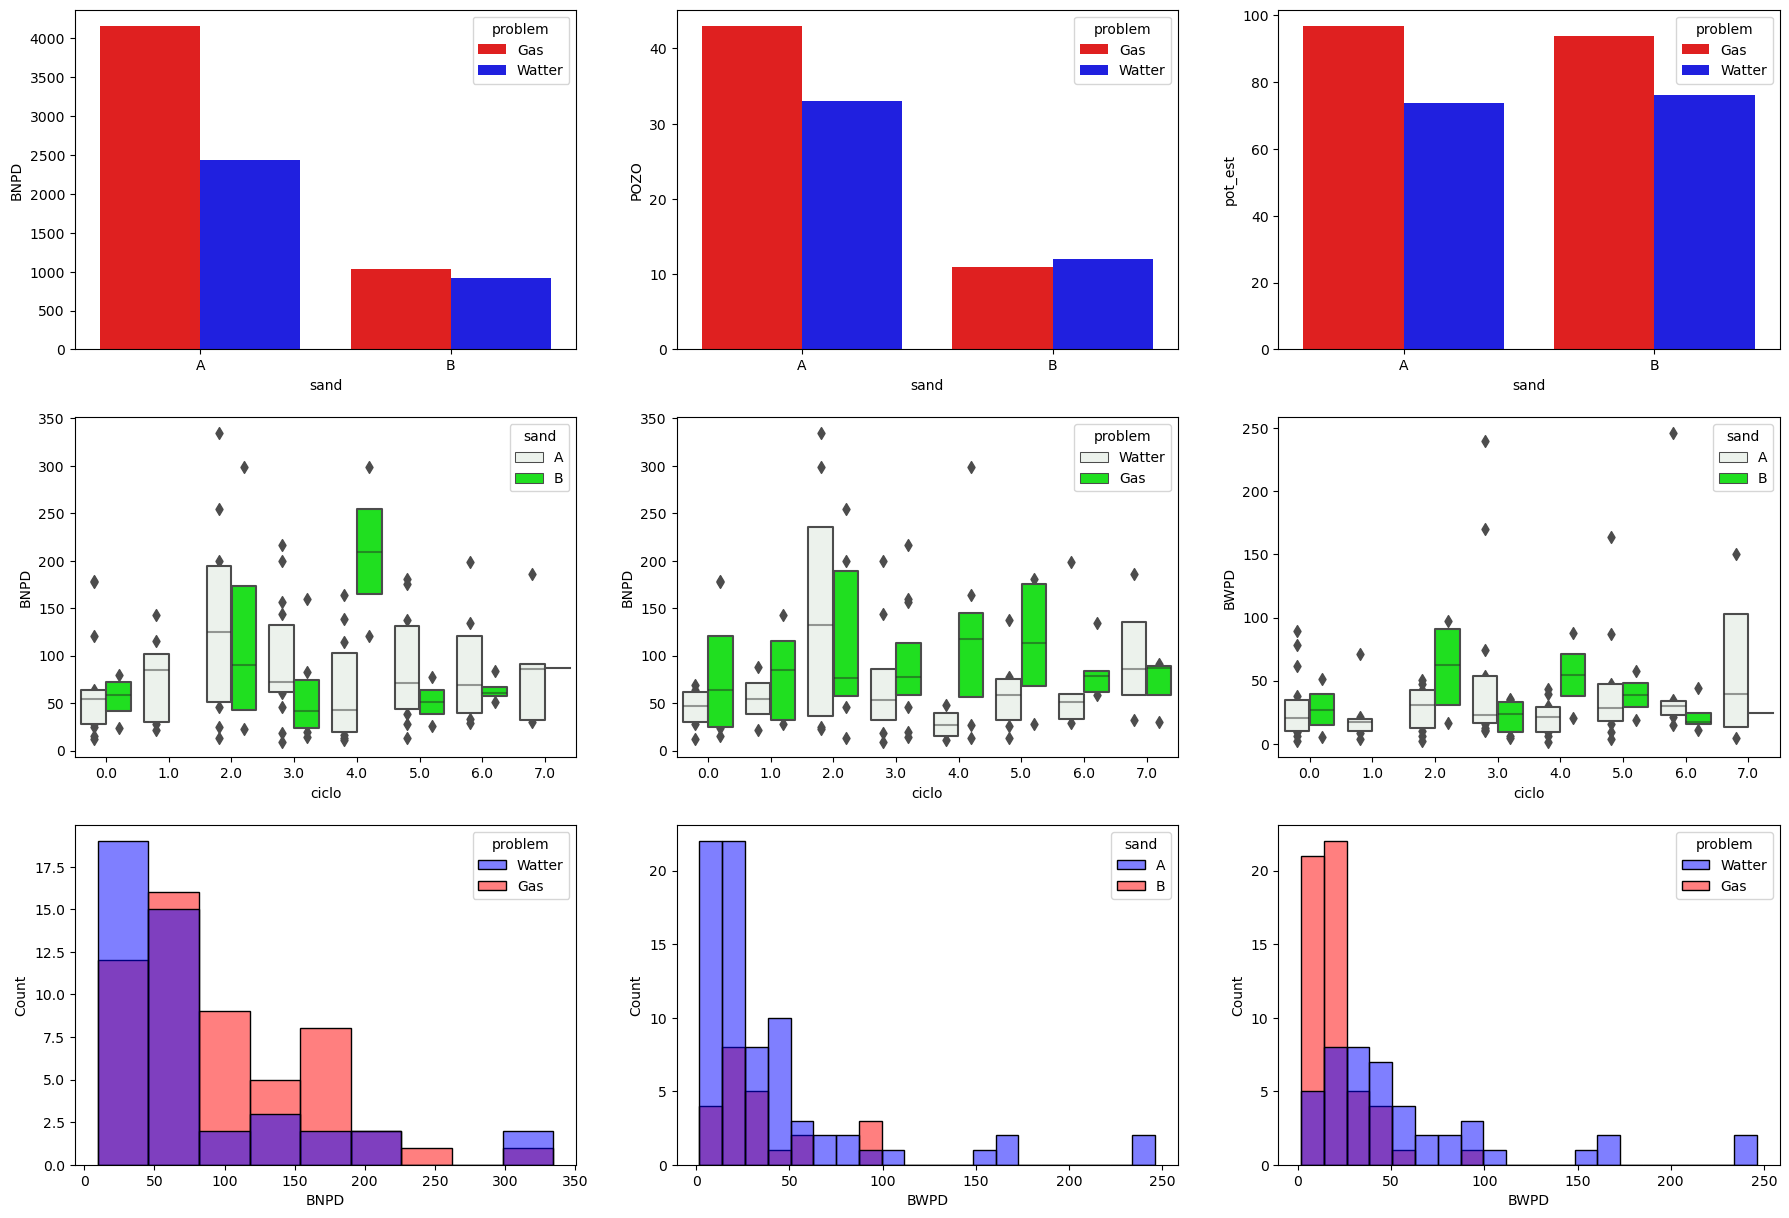

In [8]:
#Group Overview 

params = {
    'POZO':'count',
    'runlife':'mean',
    'RGP':'mean',
    'AYS':'mean',
    'Fillage':'mean',
    'BBPD':'sum',
    'BNPD':'sum',
}

df_cilco_summary = df_maestra.groupby(['sand','problem'])[['POZO','runlife','RGP','AYS','Fillage','BBPD','BNPD']].agg(params).reset_index()

df_cilco_summary["pot_est"] = df_cilco_summary["BNPD"] / df_cilco_summary["POZO"]

# df_cilco_summary


f, axes = plt.subplots(3,3,figsize=(22, 15))
_ = sns.barplot(ax=axes[0,0], data=df_cilco_summary,x="sand",y="BNPD", hue="problem", palette=["red","blue"])
_ = sns.barplot(ax=axes[0,1], data=df_cilco_summary,x="sand",y="POZO", hue="problem", palette=["red","blue"])
_ = sns.barplot(ax=axes[0,2], data=df_cilco_summary,x="sand",y="pot_est", hue="problem", palette=["red","blue"])

_ = sns.boxenplot(ax=axes[1,0] ,data=df_maestra,x="ciclo",y="BNPD", hue="sand", color="lime")
_ = sns.boxenplot(ax=axes[1,1] ,data=df_maestra,x="ciclo",y="BNPD", hue="problem", color="lime")
_ = sns.boxenplot(ax=axes[1,2] ,data=df_maestra,x="ciclo",y="BWPD", hue="sand", color="lime")

_ = sns.histplot(ax=axes[2,0],data=df_maestra, x="BNPD", hue="problem", palette=["blue","red"]) 
_ = sns.histplot(ax=axes[2,1],data=df_maestra, x="BWPD", hue="sand", palette=["blue","red"])
_ = sns.histplot(ax=axes[2,2],data=df_maestra, x="BWPD", hue="problem", palette=["blue","red"])

2).- ¿Qué tanto afecta la arena de producción de los pozos al caudal?

En función de la separación horizontal geográfica inicial de la data a la que llamaremos "Problem" con base en la predominancia de condición de producción asociadas (agua / gas), introduciremos otra separación, la arena a la cual pertenece (en pozos con profundidad de 7200 ft o menos son de la arena A y mayores a 7200 son pozos nuevos pertenecientes a la arena B). En general se observa como la arena A presenta la mayor cantidad de pozos y por ende una mayor cantidad de producción total asociada, esto es congruente con el hecho de que la arena A tiene el doble de tiempo de operación que la arena B. Sin embargo, se observa como la proyección de la arena B "Pot-Est" es similar al de la arena A, es decir un pozo nuevo en cualquier arena podría esperarse cantidad similares de hidrocarburos (si lo vemos de forma promedio general), es por ello que en general la arena de la cual produzca el pozo no tinde a afectar mucho el caudal estimados, mas sin embargo en algunos pozo para ambas arenas se presentan algunos unos casos atípicos donde el caudal es elevado, para lo cual sería necesario realizar un estudio gelógico un poco más a fondo. En resumen, la profundidad no tiende a afectar el caudal esperado.

3).-¿Qué efectos tiene los ciclos de inyección en los pozos y hasta cuántos ciclos es recomendable inyectar?

Referente al tema de los ciclos de inyección (los pozos cada cierto tiempo son inyectados con vapor caliente y esto ayuda a aumentar la temperatura de la arena y mejora la producción de hidrocarburo). En general, con base en la distribución espacial y data histórica de medidas en base a los ciclos podemos apreciar: 

* Ciclos 0-2 : la arena A tiene un ligero mayor potencial esperado asociado a la inyección en comparación a los pozos de la arena B, ya en el segundo ciclo se observa como ambas arenas responde muy bien en los incremento de producción, pero también es predominante que la inyección a largo plazo no agrega demasiada produción de agua.

* Ciclo 3 -4: en este grupo se observa que los pozos de la arena B tiende a responder de forma positiva, superior a los de la arena A, aumenta la producción de petróleo y no aumentando demasiado la de agua.

* Ciclo 5 -7: en general estos ya son pozos maduros con una varianza baja, son ya conocidos y no hay inestabilidad de producción. En estos ciclos vemos como ya la extendida inyección ha elevado la producción de agua.

Basado en los anterior se observa: *es recomedable inyectar los pozos hasta un periodo de 3-4 ciclos, superior a estos el ganancial de hidrocarburo es poco*.

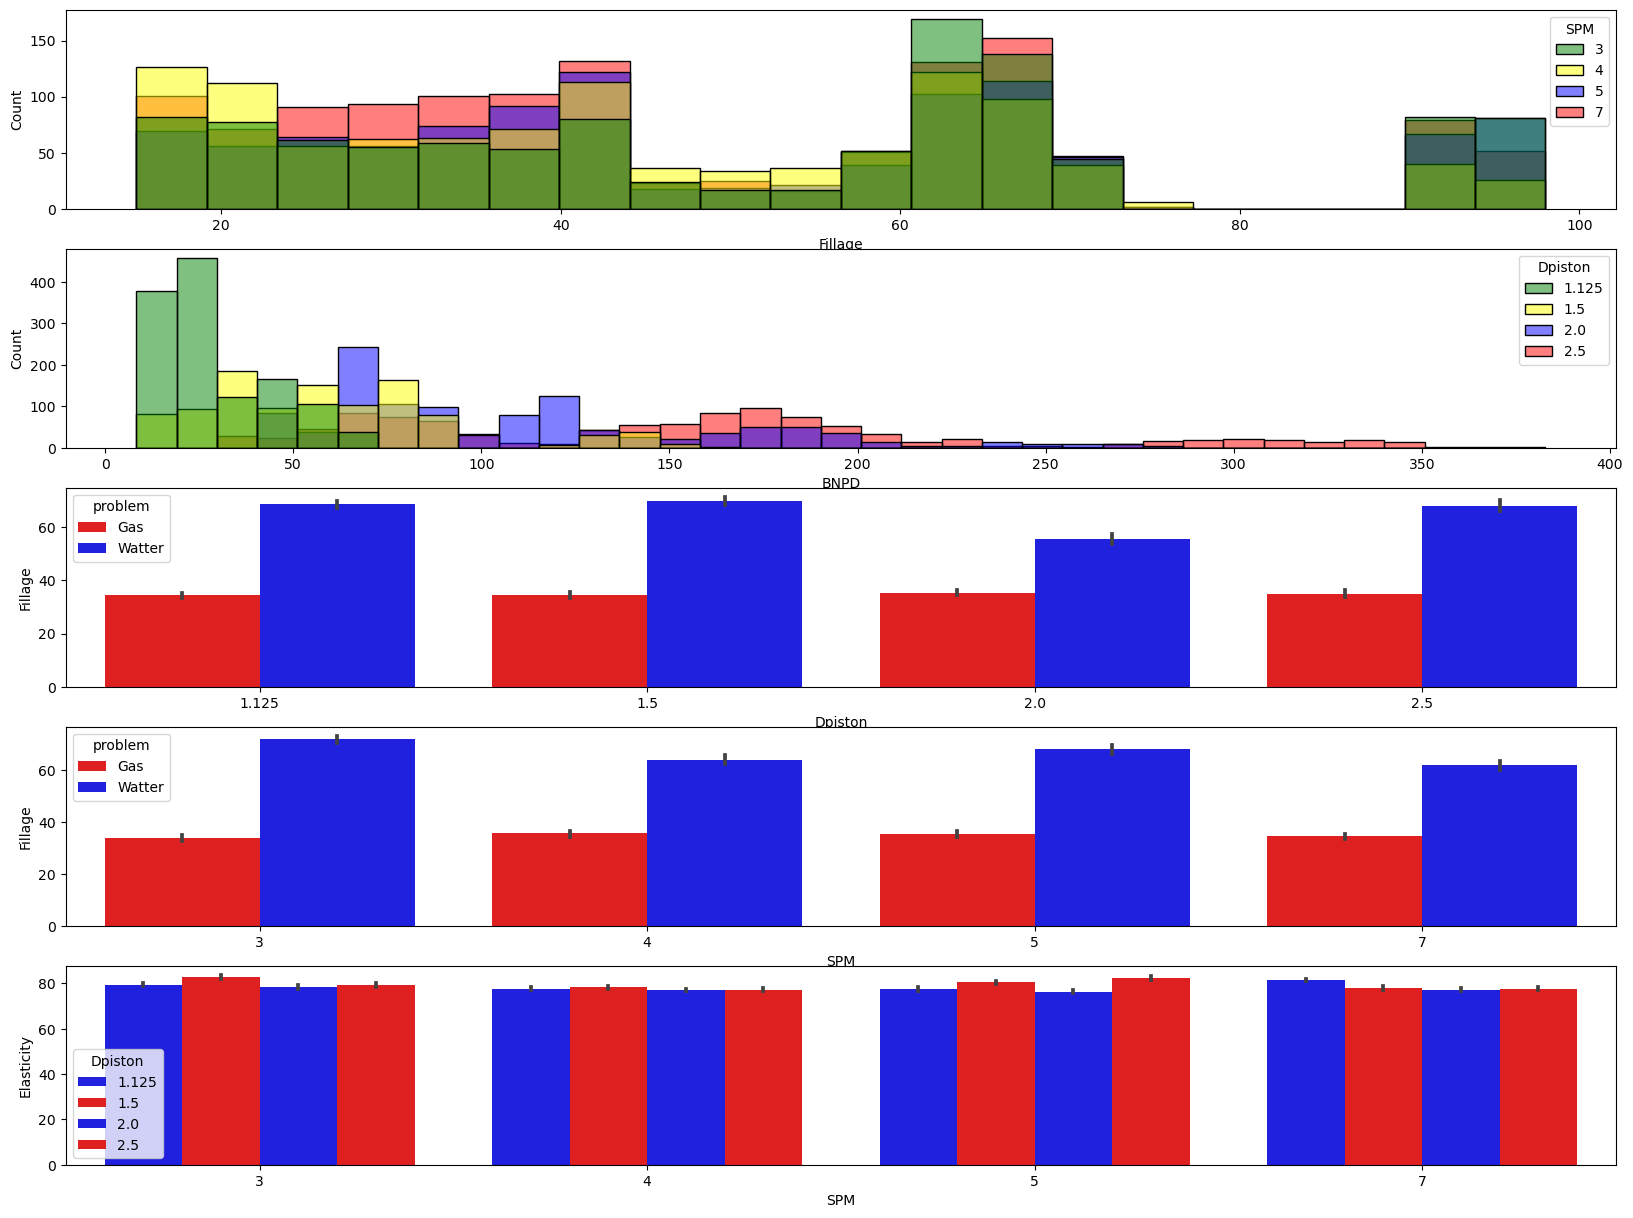

In [9]:
#Sand overview
fig, axes = plt.subplots(5,1, figsize=(20,15))

_ = sns.histplot(ax=axes[0],  data=df, x="Fillage", hue="SPM", palette=["green","yellow","blue","red"]) 
_ = sns.histplot(ax=axes[1],  data=df, x="BNPD", hue="Dpiston", palette=["green","yellow","blue","red"]) 
_ = sns.barplot(ax=axes[2], data=df, x="Dpiston", y="Fillage", hue="problem", palette=["red","blue"])
_ = sns.barplot(ax=axes[3], data=df,x="SPM",y="Fillage", hue="problem",palette=["red","blue"])
_ = sns.barplot(ax=axes[4], data=df, x="SPM", y="Elasticity", hue="Dpiston", palette=["blue","red"])

4).-¿Qué relación existe entre las variables operativas y qué tan optimizado está el campo?

Las 4 variables que miden que tan optimizados está una bomba de subsuelo en este caso son SPM (velocidad de revoluciones), Fillage (eficiencia de llenado en cada ciclo), Elasticity (que tan bien se transfiere de superficie a fondo el esfuerzo, está asociado a eficiencia) y un parámetro adicional que el pistón (tamaño del pistón):

* SPM-Fillage: lo ideal para tener mayor llenado es bajos SPM en este sentido se observa como lo más predominante son pozos con 3 spm (el más bajo del campo). existen algunos pozos con spm (5-7) con llenado bajo (>40%) que deben ser evaluados a detalle, muy probablemente en estos casos sean pozos altos productores de gas, posiblemente en estos pozos de 5-7 spm se puedan bajar a 3 y mejoraría el llenado. 

* SPM-Elasticity-Dpiston: en este caso la física dice que a mayor número de ciclos tiende a bajar la eficiencia por elasticidad, pero en general se observa que la elasticidad es constante entre los 0.75-0.85 sin importar la velocidad ni el diámetro del pistón. 

* Fillage-Dpiston-Problem: se observa qué poco influye el pistón en el llenado efectivo de fondo y en general no se podría optimizar en este sentido, sólo resaltando los casos de pozos con alto SPM, pero son muy puntuales.

Concluyendo, se observa como el campo en general está constituido por pozos de baja producción, con pozos con pistones pequeños y bajos SPM, con llenados medios-bajos pero buena eficiencia elástica, se podrían probar bombas manejadoras de gas en zonas donde éste es un problema grande.


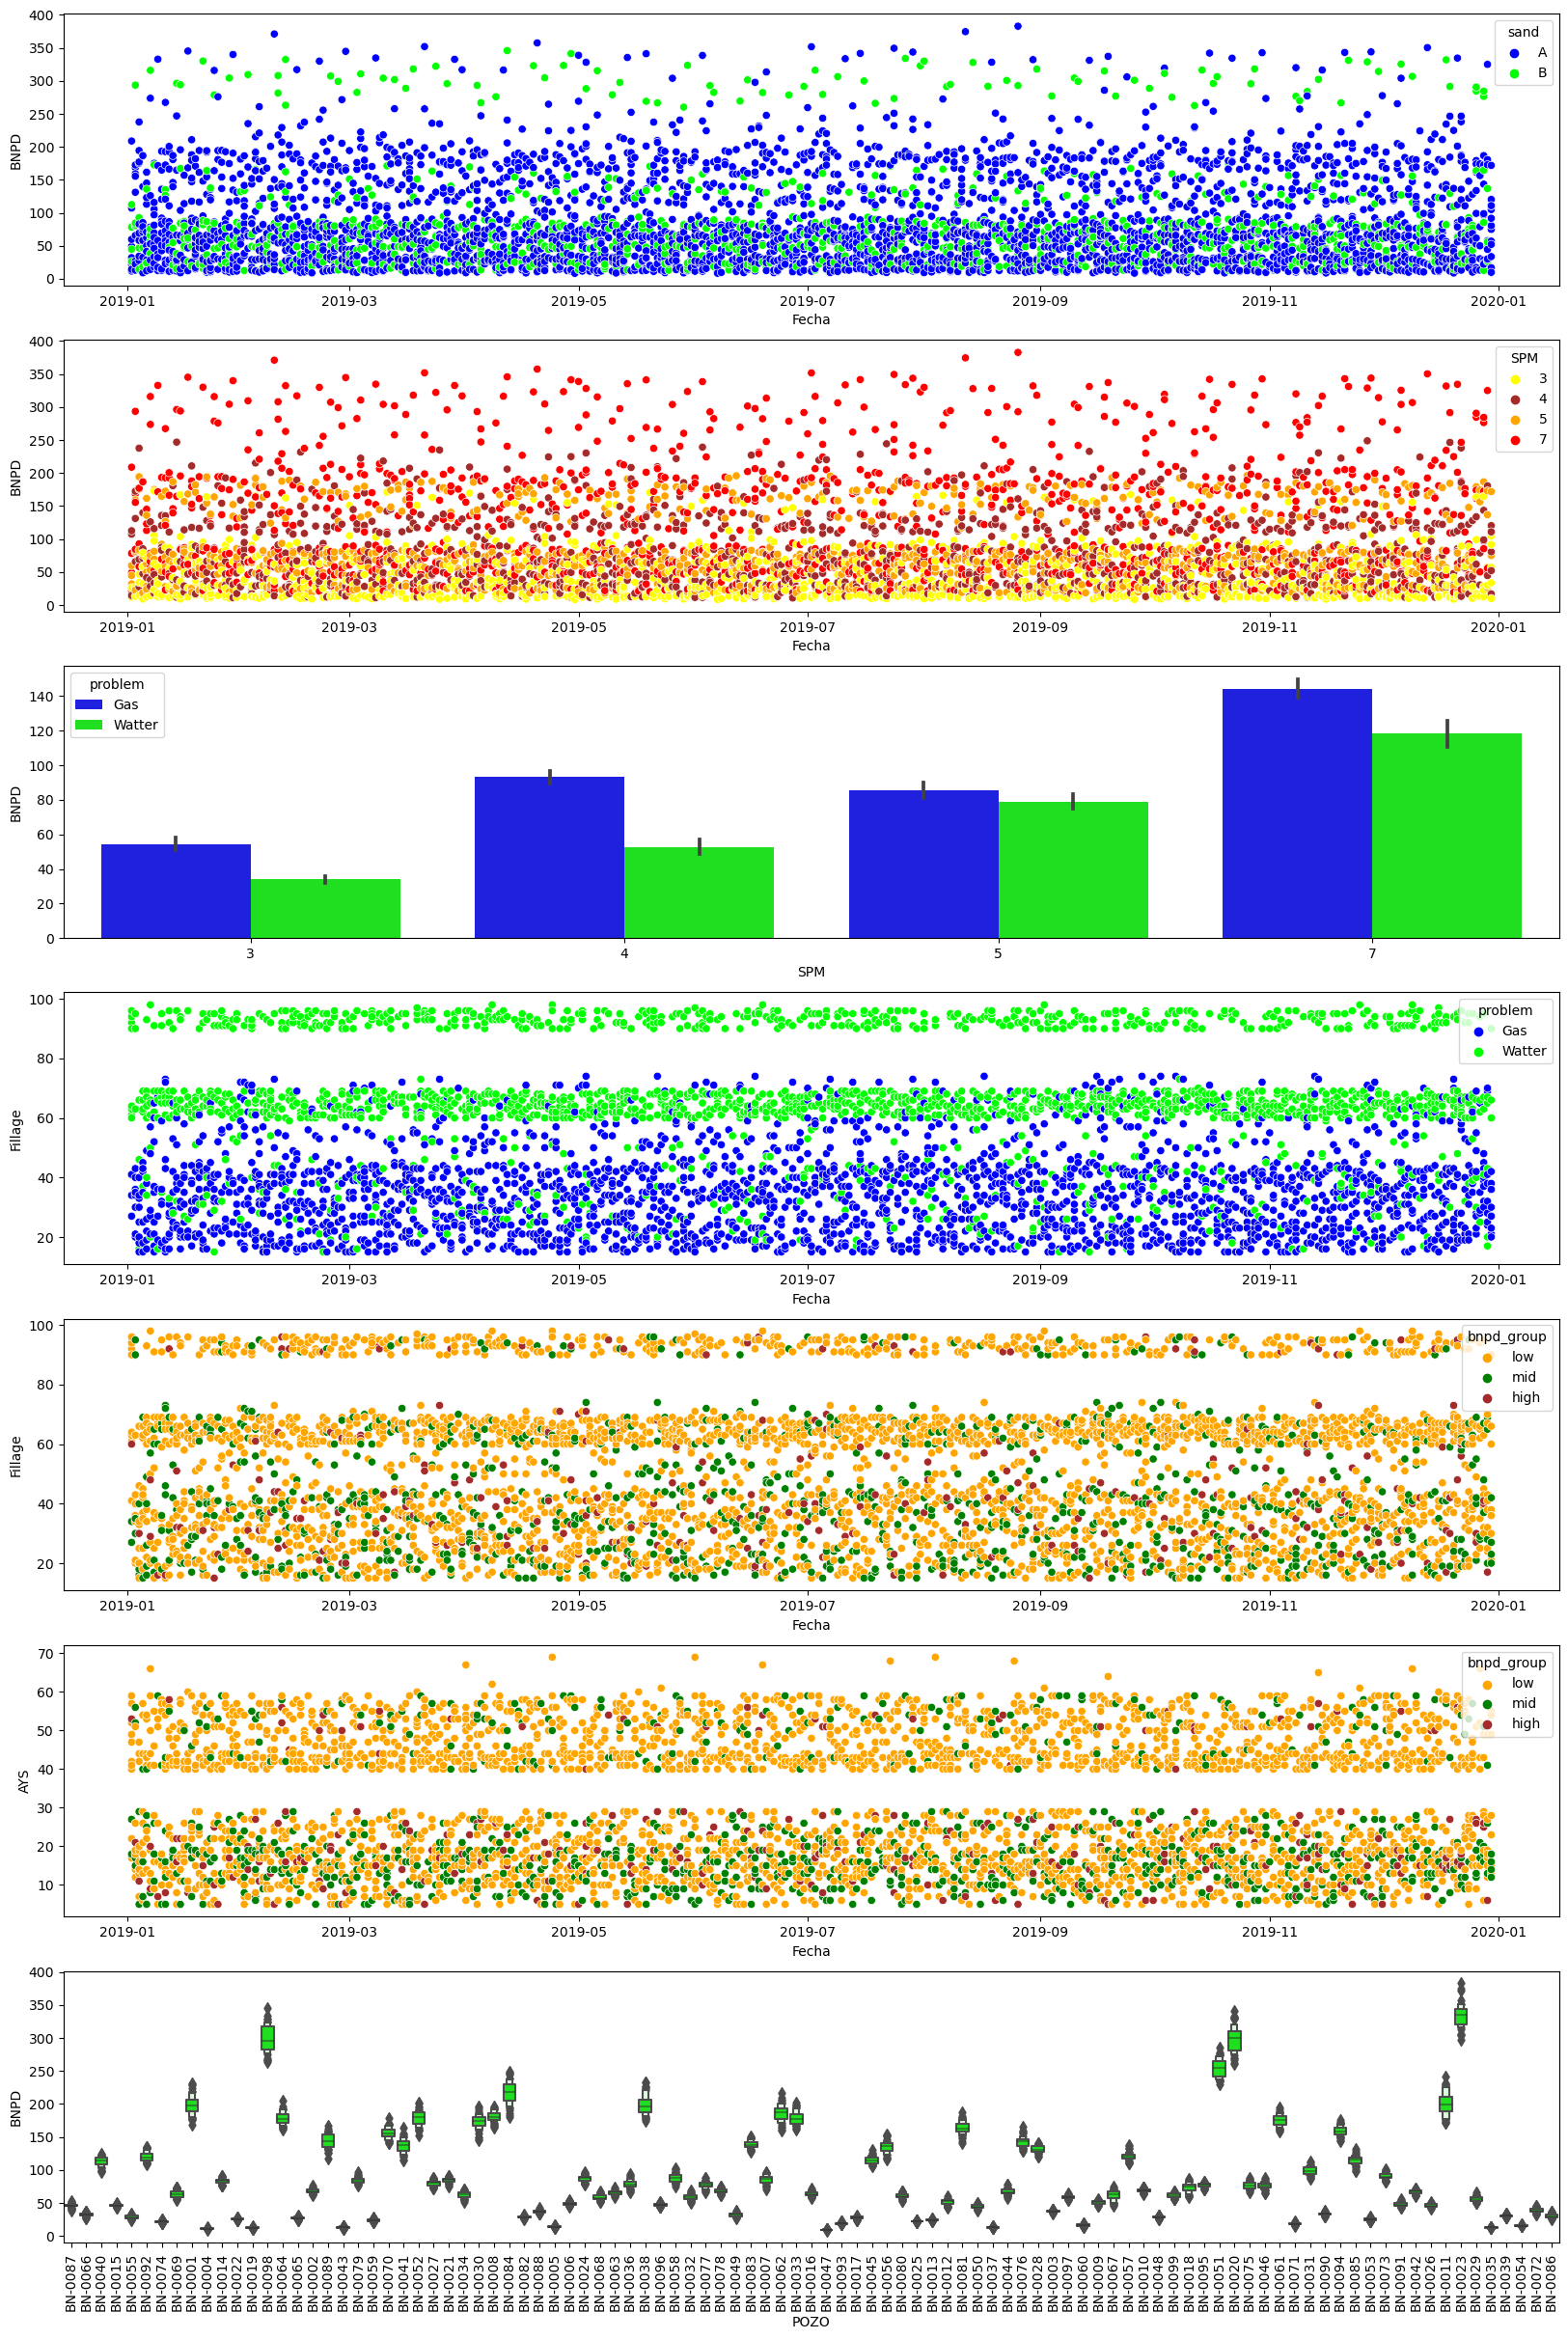

In [10]:
#Historical Overview

fig, axes = plt.subplots(7,1, figsize=(20,30))
_= plt.xticks(rotation=90)

_ = sns.scatterplot(ax=axes[0], data=df, x="Fecha", y="BNPD", hue="sand", palette=['blue','lime'])
_ = sns.scatterplot(ax=axes[1], data=df, x="Fecha", y="BNPD", hue="SPM", palette=['yellow','brown','orange','red'])
_ = sns.barplot(ax=axes[2], data=df, x="SPM", y="BNPD", hue="problem",  palette=['blue','lime'])
_ = sns.scatterplot(ax=axes[3], data=df, x="Fecha", y="Fillage", hue="problem", palette=['blue','lime'])
_ = sns.scatterplot(ax=axes[4], data=df, x="Fecha", y="Fillage", hue="bnpd_group", palette=['orange','green','brown'])
_ = sns.scatterplot(ax=axes[5], data=df, x="Fecha", y="AYS", hue="bnpd_group",  palette=['orange','green','brown'])
_ = sns.boxenplot(ax=axes[6] ,data=df, x="POZO",y="BNPD",color="lime")

5).-¿Es homogéneo el comportamiento de los pozos a lo largo del campo o existen grupo basados a su tasa de producción, qué tan confiable sería un plan de explotación en el tiempo?

Evaluando distribución histórica se observa como en general los mayores productores se encuentran distribuidos entre ambas arenas, lo cual apoya la idea inicial del potencial promedio igual en ambas arenas que vimos al inicio, pero es relevante que estos mayores productores son casos (muy pocos) que rompen la tendencia general.

En cuanto a la presupuesto de que la mayoría de los pozos estaban optimizados resulta parecer cierta pues hay una clara distribución de spm, donde los altos productores están entre 5-7 spm y la mayoría de los pozos con 3-4 spm están en zonas de baja producción, destacando que hay pozos con 7 spm en zonas de baja producción y probablemente sean los que vimos anteriormente con bajo llenado y estos podrían ser los pozos pendientes por optimizar, pero son poco. 

Resalta que el problema del gas está asociado a baja producción inidividual, pues en ningún caso se observa un buen llenado de bomba o buen potencial en pozos donde este problema predomina, en el caso del agua si se observa como existen grupos claramente definidos y algunos presentan buena producción (aquellos casos donde hay buen llenado), la relación entre buen llenado y altos productores es clara en pozos con velocidad entre 5-7 spm  y en este caso ya se tiene un AYS superior a 40% (optimizados). Es relevante destacar que los productores de gas son los pozos que en conjunto acumulan el 60% de la produccion del campo.

En resumen, vemos como en general los pozos son bajos productores con sus excepciones. Están bien sectorizados los bajos y altos productos y tiene baja variación en el tiempo poco por lo cual se pueden hacer claros planes de explotación.

Aun cuando en los análisis de arriba hemos visto una correlación entre variables debemos recalcar que ninguna variable presenta una cerrada correlación con otro (pues toda variable registrada es una consecuencia multicausal en el área de estudio (es decir siempre afectara el agua, el gas, incluso variables del área y roca que no hemos considerado))

En este paso intentaremos ver si existe alguna correlacionan entre las variables de forma lineal (1 a 1).
 
* SP: correlación altísima con "Lon_superficie" esperable pues la misma no es más que la "Lon_superficie" en fondo y entre ellos solo afecta la eficiencia elástica.
* RGP: alta relación con AYS y fillage (uno sube otro baja), y con XCORD (ya vimos que se puede separar el campo en 2 zonas basados en coordenadas).
* AYS: alta relación con RGP y fillage (uno sube otro baja), y con XCORD (ya vimos que se puede separar el campo en 2 zonas basados en coordenadas). 
* Fillage: dependencia casi directa del AYS y RGP y buen ajuste con coordenada XCORD.
* BBPD: En general presenta buena relación Dpiston, pero decir de forma directa que al aumentar el Dpiston aumentará el caudal es errado, esta relación viene a reafirmar que el campo está altamente optimizado pues el Dpiston ha sido seleccionado para el mayor caudal.


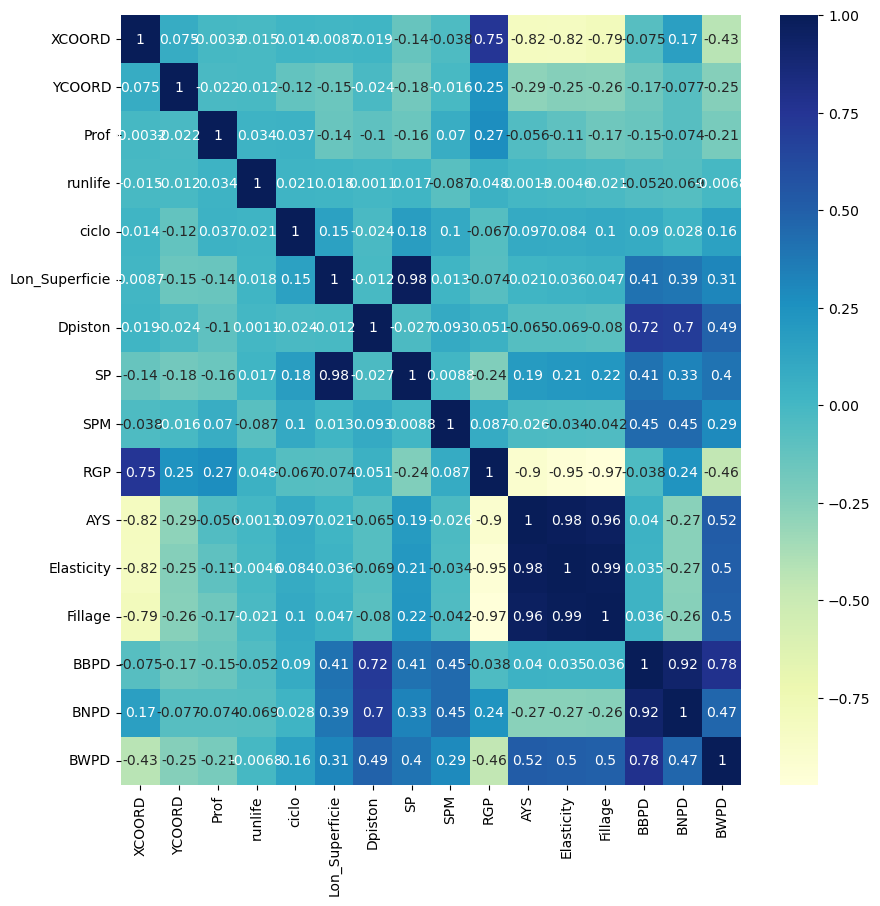

In [11]:
#Variables correlation
correlations= df_maestra.corr()
indx = correlations.index
_=plt.figure(figsize=(10,10))
_= sns.heatmap(df_maestra[indx].corr(),annot=True,cmap="YlGnBu")

Antes de continuar hacemos una tabla de relación entre variables, es importante mencionar que de la misma podemos destacar las siguientes relaciones predominantes:

*BBPD : buena relación variables operacionales (Lon. superficie, Dpiston, Sp, SPM), de estas 3 escogeremos Dpiston para entrenar junto a las variables de ubicación geográficas, que aún cuando su correlación son bastantes bajas, es una solicitud comercial introducirlas como data input.

*AYS : la relación a variables operacionales es baja por ellos nos quedaremos sólo con las variables de ubicación geográficas que presentan buena correlación.

**======================================================Data Modeling===================================================**

In [12]:
#Funcion de calculo del modelo
def calcular_modelo(lista_de_variables_x,target,data,show_summary=True, modelo='arbol',k=1,returnPredicted=False,returnModel=False):
    X = data[lista_de_variables_x]
    y = data[target].astype(int) 
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=5)
    
    if (modelo=='arbol'):
        clf = DecisionTreeClassifier(max_depth = 5, criterion ='entropy')

    if (modelo=='rl'):
        clf = LogisticRegression()

    if (modelo=='knn'):
        clf = neighbors.KNeighborsClassifier(n_neighbors=k)

    if (modelo=='xg'):
        clf = xgb.XGBClassifier()

    if (modelo=='gbm'):
        clf = ltb.LGBMClassifier()
    
    if (modelo=='svc'):
        clf = SVC(random_state=5)
    
    if (modelo=='gaussian'):
        clf = GaussianNB()

    if (modelo=='mlp'):
        clf = MLPClassifier(random_state = 5,max_iter=500)

    if (modelo=='sgdc'):
        clf = SGDClassifier(random_state = 5)

    if (modelo=='mnb'):
        clf = MultinomialNB()

    if (modelo=='rfc'):
        clf = RandomForestClassifier(random_state = 5,class_weight="balanced")

    if (modelo=='gbc'):
        clf = GradientBoostingClassifier(random_state = 5)
        
    model_dt = clf.fit(X_train,y_train)
    y_pred_dt = model_dt.predict(X_test)
    
    accuracy = accuracy_score(y_test,y_pred_dt)
    precision = precision_score(y_test,y_pred_dt,average='micro')
    recall = recall_score(y_test,y_pred_dt,average='micro')
    f1 = f1_score(y_test,y_pred_dt,average='micro')
    confusionMatrix = confusion_matrix(y_test, y_pred_dt)

    if (returnModel):
        return model_dt
    
    if (show_summary):
        print(f"Accuracy : {accuracy} , precision_score: {precision} , recall_score: {recall} ,f1_score :{f1}")

    if(returnPredicted):
        y_pred_dt
    else:
        return accuracy,precision,recall,f1,confusionMatrix

**Caudal Bruto**

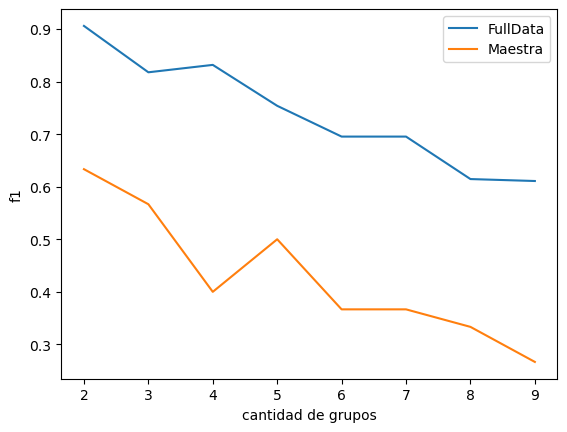

In [13]:
#Escogiendo autogrupos con decision tree

df1 = df.copy(deep=True)

#Arbol de deicion
resumen_df = pd.DataFrame(columns=['cantidad de grupos','f1'])

lista_de_variables_x = ['XCOORD', 'YCOORD', 'Prof','Dpiston']

for i in range(2,10):
    df1['bbpd_group_auto']=pd.qcut(df1['BBPD'],i)
    label_encoder = LabelEncoder()
    df1['bbpd_group_auto'] = label_encoder.fit_transform(df1['bbpd_group_auto'])
    accuracy,precision,recall,f1,cm = calcular_modelo(lista_de_variables_x,'bbpd_group_auto',df1,False)
    resumen_df = resumen_df.append({'cantidad de grupos':i,'f1':f1},ignore_index=True)

_ = sns.lineplot(data=resumen_df,x="cantidad de grupos",y="f1",label="FullData")

df1 = df_maestra.copy(deep=True)
resumen_df = pd.DataFrame(columns=['cantidad de grupos','f1'])

for i in range(2,10):
    df1['bbpd_group_auto']=pd.qcut(df1['BBPD'],i)
    label_encoder = LabelEncoder()
    df1['bbpd_group_auto'] = label_encoder.fit_transform(df1['bbpd_group_auto'])
    accuracy,precision,recall,f1,cm = calcular_modelo(lista_de_variables_x,'bbpd_group_auto',df1,False)
    resumen_df = resumen_df.append({'cantidad de grupos':i,'f1':f1},ignore_index=True)

_ = sns.lineplot(data=resumen_df,x="cantidad de grupos",y="f1",label="Maestra")

En el gráfico anterior podemos ver cómo, para efectos de modelado, resulta mucho más funcional la data cruda global no resumida de la tabla maestra. Adicionalmente se ve cómo al aumentar la cantidad de grupos entre los pozos baja la capacidad de los modelos para predecir el agrupamiento del pozo, el número ideal estaría entre 2 y 3 grupos, por razón de negocio nos quedaremos con 3 grupos sectorizados de forma manual (bajos, medioa y altos).

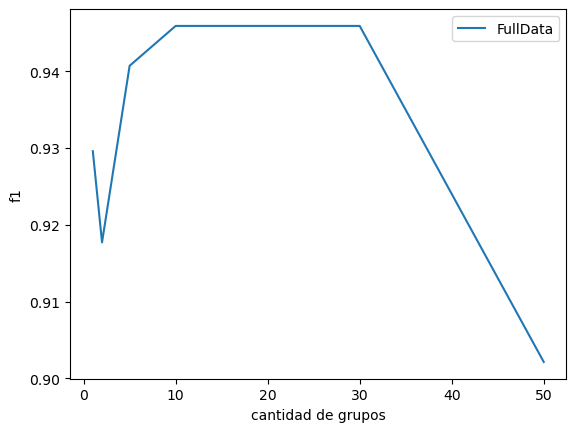

In [14]:
#Escogiendo la cantidad de N con Knn
df1 = df.copy(deep=True)

lista_de_variables_x = ['XCOORD', 'YCOORD', 'Prof','Dpiston']

label_encoder = LabelEncoder()
df1['bbpd_group'] = label_encoder.fit_transform(df1['bbpd_group'])

resumen_k = pd.DataFrame(columns=['cantidad de grupos','f1'])
for i in [1,2,5,10,20,30,50]:
    accuracy,precision,recall,f1,cm = calcular_modelo(lista_de_variables_x,'bbpd_group',df1,False,'knn',i)
    resumen_k = resumen_k.append({'cantidad de grupos':i,'f1':f1},ignore_index=True)

_ = sns.lineplot(data=resumen_k,x="cantidad de grupos",y="f1",label="FullData")

Con base en la cantidad de grupos para el método de knn se observa como con 10 grupos se obtienen los mejores resultados.

StandardScaler()

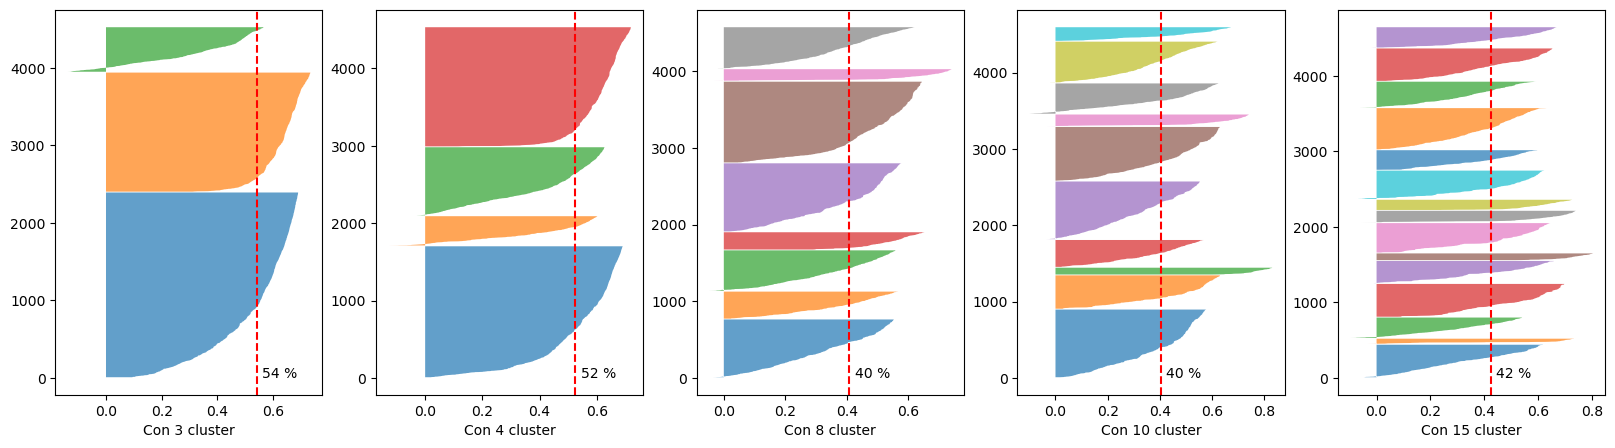

In [15]:
#Evaluando los Cluster por silhouette
fig, axes = plt.subplots(1, 5,figsize=(20,5))

df1 = df.copy(deep=True)
X=df1[['BBPD','AYS']].values

sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

for index,n_clusters in enumerate([3,4,8,10,15]):
    kmeans = KMeans(n_clusters=n_clusters,max_iter=1000, random_state=10)
    y_kmeans = kmeans.fit_predict(X)
    sample_silhouette_values = silhouette_samples(X, y_kmeans)
    silhouette_avg = silhouette_score(X, y_kmeans)
    y_lower = 10
    _= axes[index].set_xlabel("Con " + str(n_clusters) + " cluster")
    _=axes[index].axvline(x=silhouette_avg, color="red", linestyle="--")
    _=axes[index].text(silhouette_avg+0.02, 0.5, str(int(silhouette_avg*100)) + " % ")
    for i in range(n_clusters):
        ith_cluster_silhouette_values =sample_silhouette_values[y_kmeans == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        _=axes[index].fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,alpha=0.7)
        y_lower = y_upper + 10

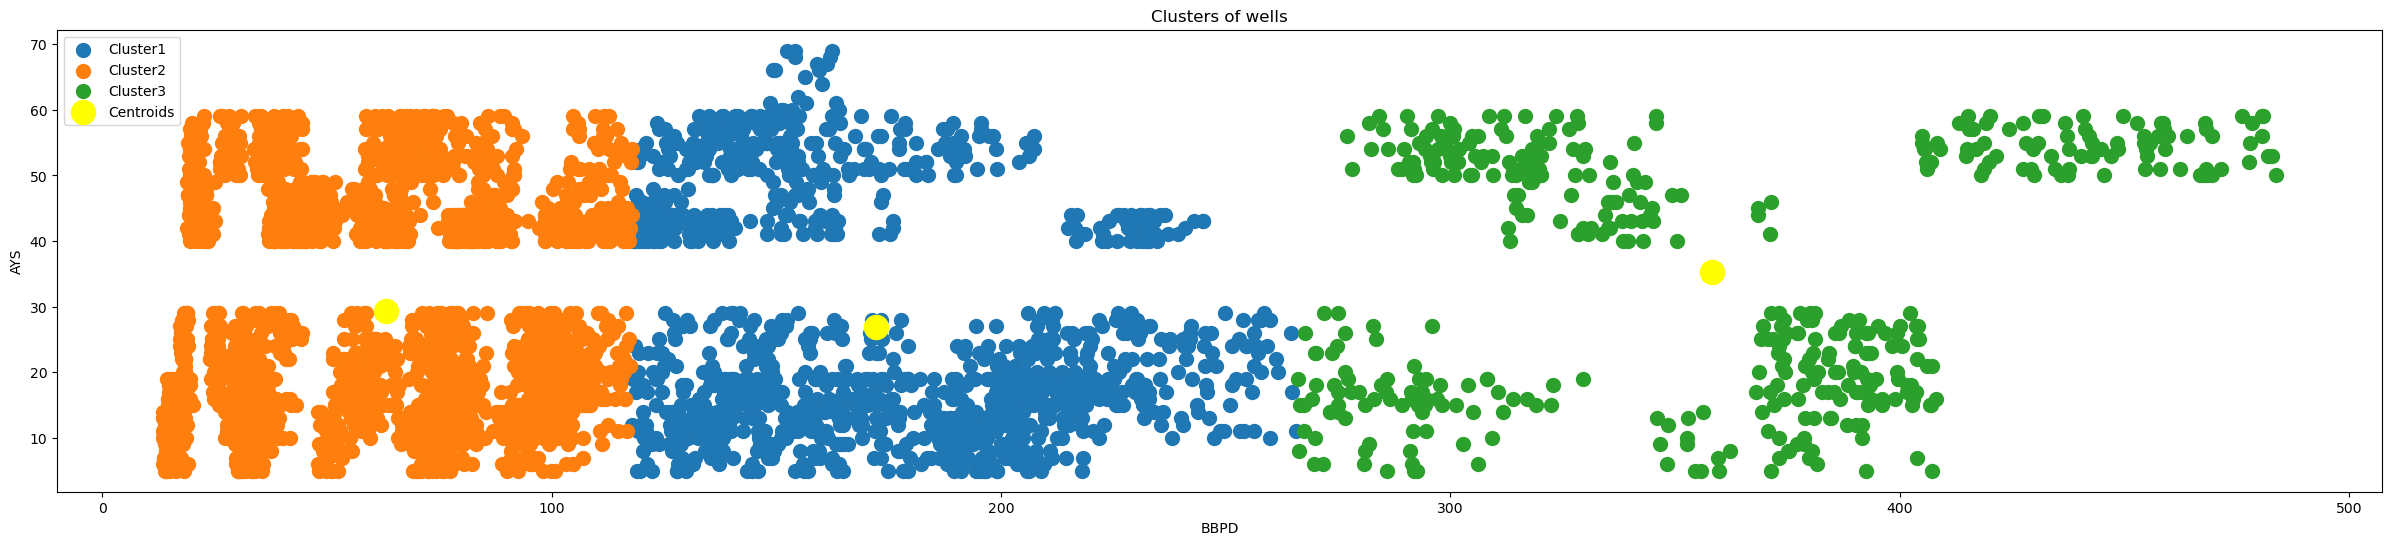

In [16]:
#Evaluando los Cluster por centroides con 3 clusters

df1 = df.copy(deep=True)
X=df1[['BBPD','AYS']].values
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
df1['prod_group']=y_kmeans
_=plt.subplots(1,1, figsize=(30,6))

for i in [0,1,2,]:
    _= plt.scatter(X[y_kmeans == i, 0], X[y_kmeans == i, 1], s = 100, label = 'Cluster' + str(i+1))

_= plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
_= plt.title('Clusters of wells')
_= plt.xlabel('BBPD')
_= plt.ylabel('AYS')
_= plt.legend()
_= plt.show()


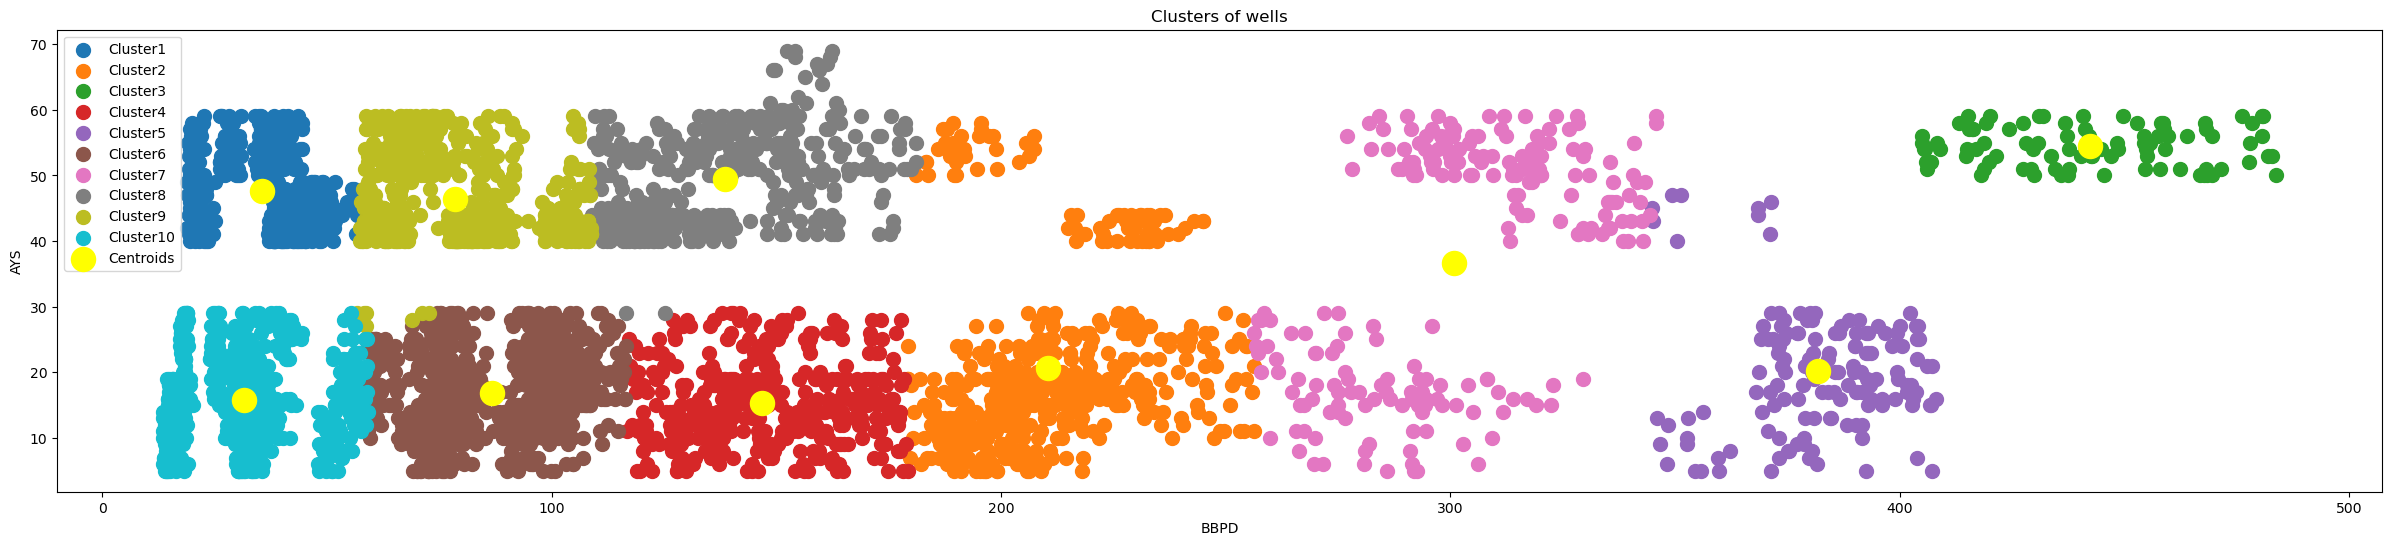

In [17]:
#Evaluando los Cluster por centroides con 10 clusters

df1 = df.copy(deep=True)
X=df1[['BBPD','AYS']].values
kmeans = KMeans(n_clusters = 10, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
df1['prod_group']=y_kmeans
_=plt.subplots(1,1, figsize=(30,6))

for i in [0,1,2,3,4,5,6,7,8,9]:
    _= plt.scatter(X[y_kmeans == i, 0], X[y_kmeans == i, 1], s = 100, label = 'Cluster' + str(i+1))

_= plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
_= plt.title('Clusters of wells')
_= plt.xlabel('BBPD')
_= plt.ylabel('AYS')
_= plt.legend()
_= plt.show()

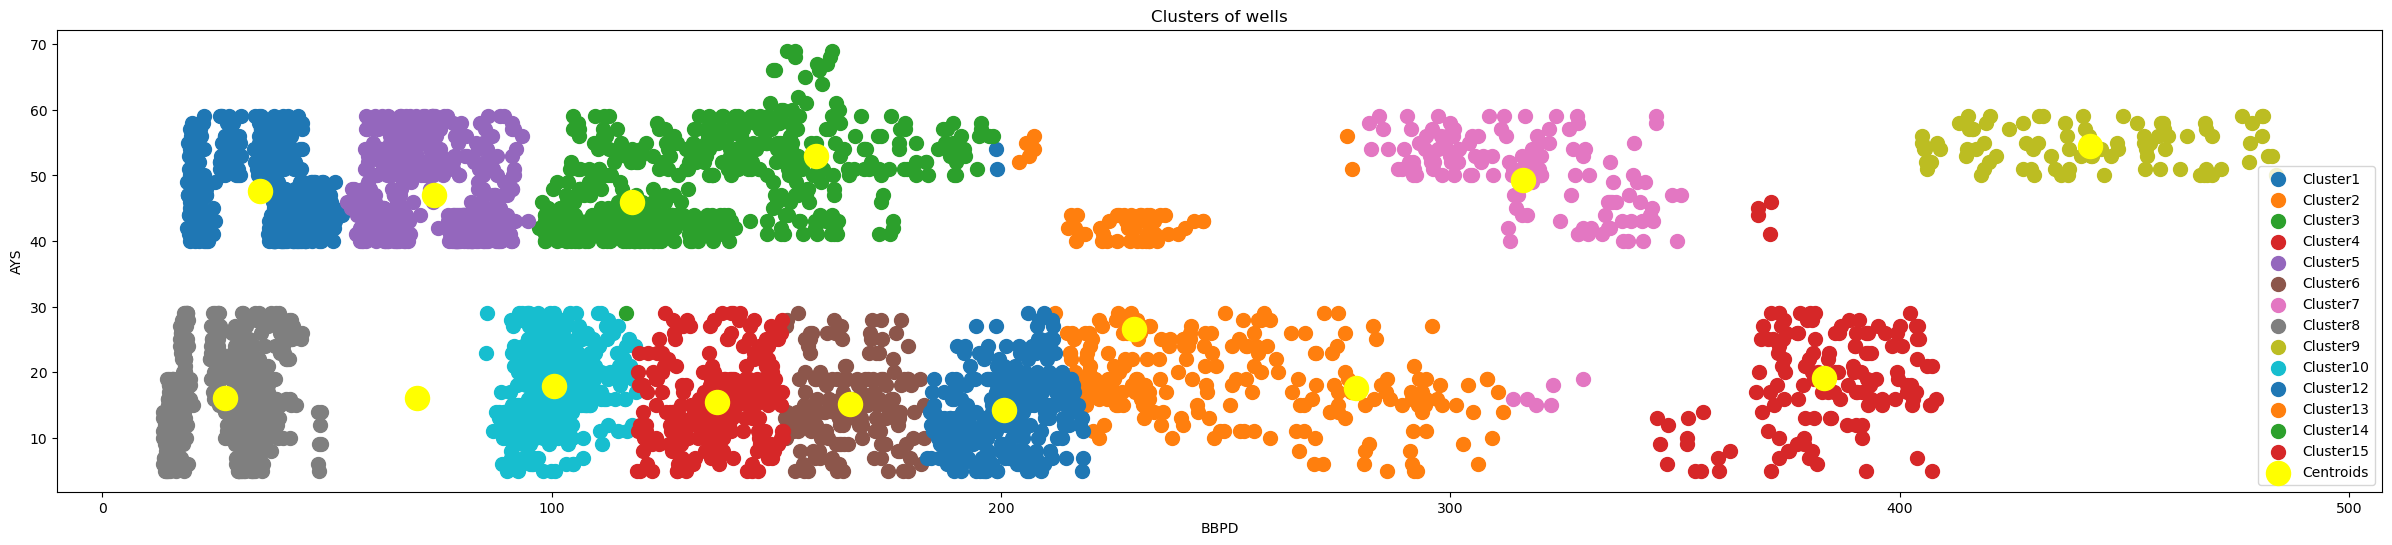

In [18]:
#Evaluando los Cluster por centroides con 15 clusters

df1 = df.copy(deep=True)
X=df1[['BBPD','AYS']].values
kmeans = KMeans(n_clusters = 15, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
df1['prod_group']=y_kmeans
_=plt.subplots(1,1, figsize=(30,6))

for i in [0,1,2,3,4,5,6,7,8,9,11,12,13,14]:
    _= plt.scatter(X[y_kmeans == i, 0], X[y_kmeans == i, 1], s = 100, label = 'Cluster' + str(i+1))

_= plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
_= plt.title('Clusters of wells')
_= plt.xlabel('BBPD')
_= plt.ylabel('AYS')
_= plt.legend()
_= plt.show()

De todo lo anterior podemos sacar las siguientes datos relevantes:

* Podriamos clasificar el cluster en 3 grupos (el mismo que trae negocio haciendo historicamente): si es cierto que el indice de silhouette muestra la clasificacion mas alta al ver la clasificacion visual de los cluster entre AYS vs BBPD vemos condiciones de barreras difusas y con un rango alto de posible caudal esperado donde se dificultaria determinar si un pozos es bajo, medio o alto y esto podria ser economicamente muy riesgozo es por ello que descartamos este escenario

* Clasificar el cluster en 10 grupos: el estudio del codo muestra un F1 muy bueno, ademas el indice de silhouette muestra una clasificacion aceptable no tan buena pero aceptable, si ahora vemos las visualizacion fisica de AYS vs BBPD vemos cluster no tan extensos en rango como en el caso anterior y aun cuando siempre se dificulta determinar que tanto dara un pozo alto productor los cluster difusosse enuentran por encima d elos 200 BBPD donde se supera el minimo de produccion requerido para pagar operaciones de perforacion, es por eso que esta opcion resulta la mas idonea

* Este clasificacion por el diagrama del codo muestra poca mejora con respecto a los 10 grupos, sumado a esto el indice silhouette mejora un poco pero no excesivamente y si sumamos que esto serian mayor gasto computacional que no se vera reflejado en clusters de rango de produccion mas bajo, se descarta esta opcion para evitar sobrecomplejizar el caso de estudio 

basado en lo anterior se concluye que continuaremos con 10 grupos lo cual resulta en cluster bn separados y mas o menos homogeneos, esto estudiando la data cruda que nos aporta nuestroa dataSet (todas las pruebas de produccion), resalta que nuevamente el AyS resulta una variabl de alto impacto especialmente en pozos entre los 180 hasta los 420 bbpd donde al acercase a mayor caudal aumenta la presenciald de agua y crea incluso subcluster especialmente en pozos entre (180-320 bbpd), se observa como las mayores medidas del campo se obtuvieron en presencia de alto corte de agua (>50%)

    prod_group  POZO       SPM          RGP        AYS        BBPD        bnpd
0            3     4  6.500000  1029.399758  24.414614  321.407794  253.250000
1           11     2  5.000000  1051.452415  15.336957  244.955806  208.000000
2            8     3  6.333333   618.242995  40.397585  364.292670  194.666667
3            5     2  7.000000   896.188889  19.244444  208.549468  167.500000
4            6     6  5.500000   616.623430  39.552576  244.251251  141.500000
5            1     1  5.000000   893.000000  42.043478  229.290462  132.000000
6           14     2  5.500000   997.282609  12.209420  135.284563  118.500000
7           13     7  4.428571   663.179089  32.762388  145.895126   96.142857
8            9    11  5.181818  1008.893983  18.064734  110.092047   89.545455
9           10    18  4.888889   958.513392  17.638084  107.224515   87.500000
10          12     1  3.000000   423.288889  54.022222  188.687292   86.000000
11           2     5  5.800000   585.361932  45.2106

Text(0.5, 1.0, 'Clusters of wells')

Text(0.5, 0, 'XCOORD')

Text(0, 0.5, 'YCOORD')

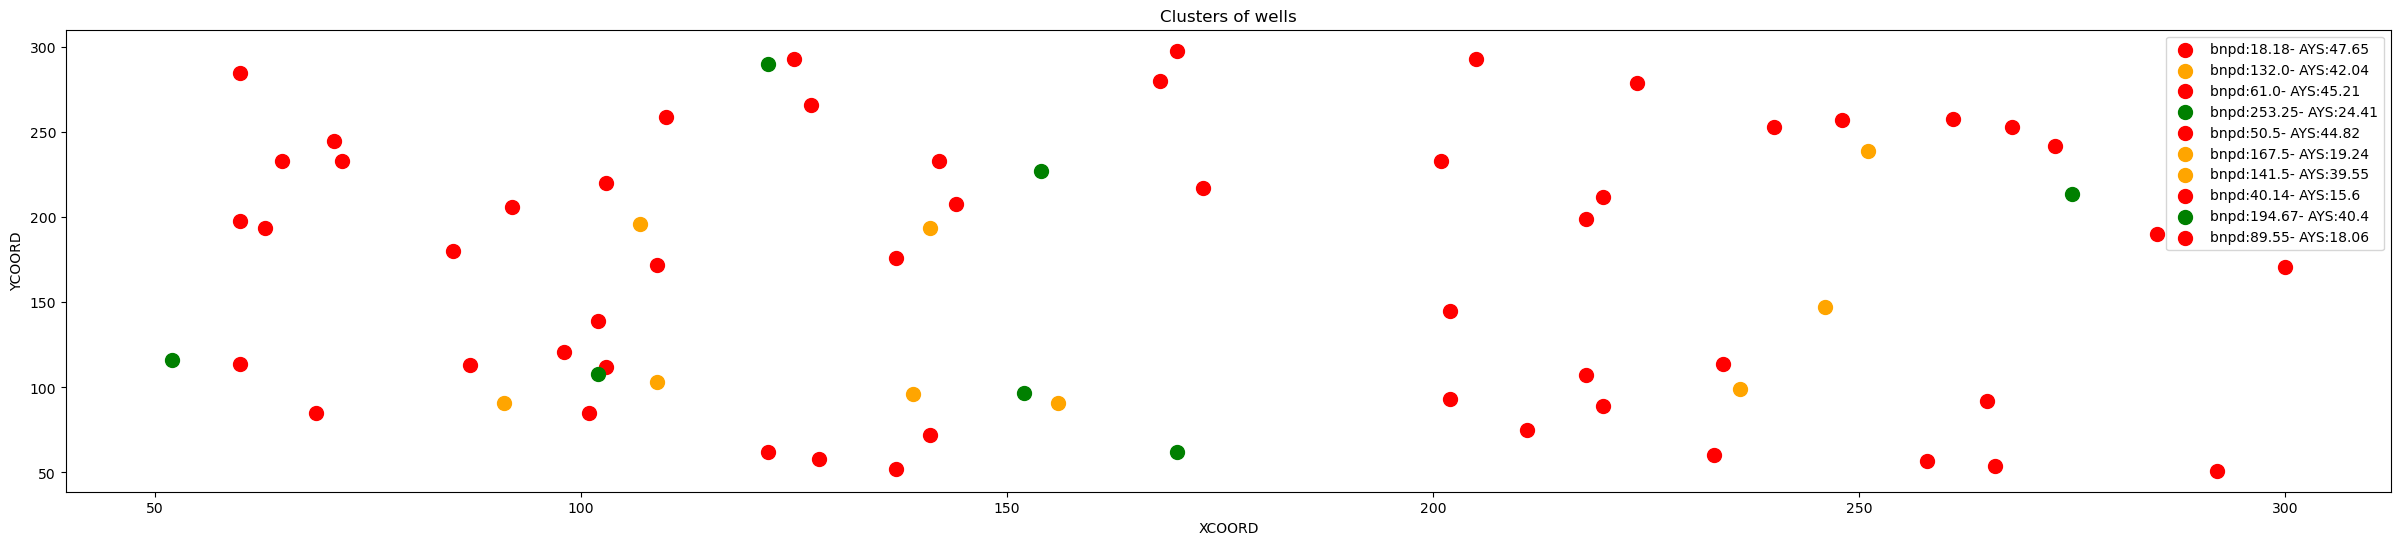

In [19]:
params = {
    'XCOORD':'mean',
    'YCOORD':'mean',
    'Prof':'mean',
    'runlife':'mean',
    'ciclo':'mean',
    'Lon_Superficie':'mean',
    'Dpiston':'mean',
    'SP':'mean',
    'SPM':'mean',
    'RGP':'mean',
    'AYS':'mean',
    'Elasticity':'mean',
    'Fillage':'mean',
    'BBPD':'mean',
    'BNPD':'mean',
    'prod_group':'mean',
}

df_maestra_grouped = df1.groupby(['POZO'])[['XCOORD','YCOORD',"Prof",'runlife','ciclo','Lon_Superficie','Dpiston','SP','SPM','RGP','AYS','Elasticity','Fillage','BBPD','BNPD','prod_group']].agg(params).reset_index()
df_maestra_grouped['prod_group'] = df_maestra_grouped['prod_group'].round(0).astype(int)
params={
    'POZO':'count',
    'SPM':'mean',
    'RGP':'mean',
    'AYS':'mean',
    'BBPD':'mean',
    'bnpd':'mean'
}
df_maestra_grouped['bnpd']=(df_maestra_grouped['BBPD'] * (100 - df_maestra_grouped['AYS'])/100 ).astype(int)
df2 = df_maestra_grouped.groupby(['prod_group'])[['POZO','SPM','RGP','AYS','BBPD','bnpd']].agg(params).sort_values(by=['bnpd'],ascending=False).reset_index()
print(df2)

fig, axes = plt.subplots(1,1, figsize=(30,6))

for i in [0,1,2,3,4,5,6,7,8,9]:
    color = 'red'
    if (df2.loc[df2['prod_group']==i]['bnpd'].round(2).values[0]>=180):
        color = 'green'
    elif (df2.loc[df2['prod_group']==i]['bnpd'].round(2).values[0]>=100):
        color = 'orange'
    label = 'bnpd:' + df2.loc[df2['prod_group']==i]['bnpd'].round(2).astype(str).values[0] + '- AYS:' + df2.loc[df2['prod_group']==i]['AYS'].round(2).astype(str).values[0]
    _= plt.scatter(df_maestra_grouped.loc[df_maestra_grouped['prod_group']==i]['XCOORD'], 
                  df_maestra_grouped.loc[df_maestra_grouped['prod_group']==i]['YCOORD'], 
                  s = 100, c=color, label = label)

plt.title('Clusters of wells')
plt.xlabel('XCOORD')
plt.ylabel('YCOORD')
plt.legend()
plt.show()

El analisis anterior se refiere a llevar la clusterizacion que vimos a nivel de modelo a nivel de campo/negocio en este caso vemos como no existe una clara distribucion del campo basado en la idea de 3 cluster (bajo, medio alto), y que en general 4 subcluster de modelo serian bajos productos, 3 medios y 2 altos. En este momento recobra mucha importancia el uso de herramientas computacionales para predecir cuanto seria la tasa del pozos, en espcial pues los pozos altos productosres, se encuentran cerca a bajos productores.

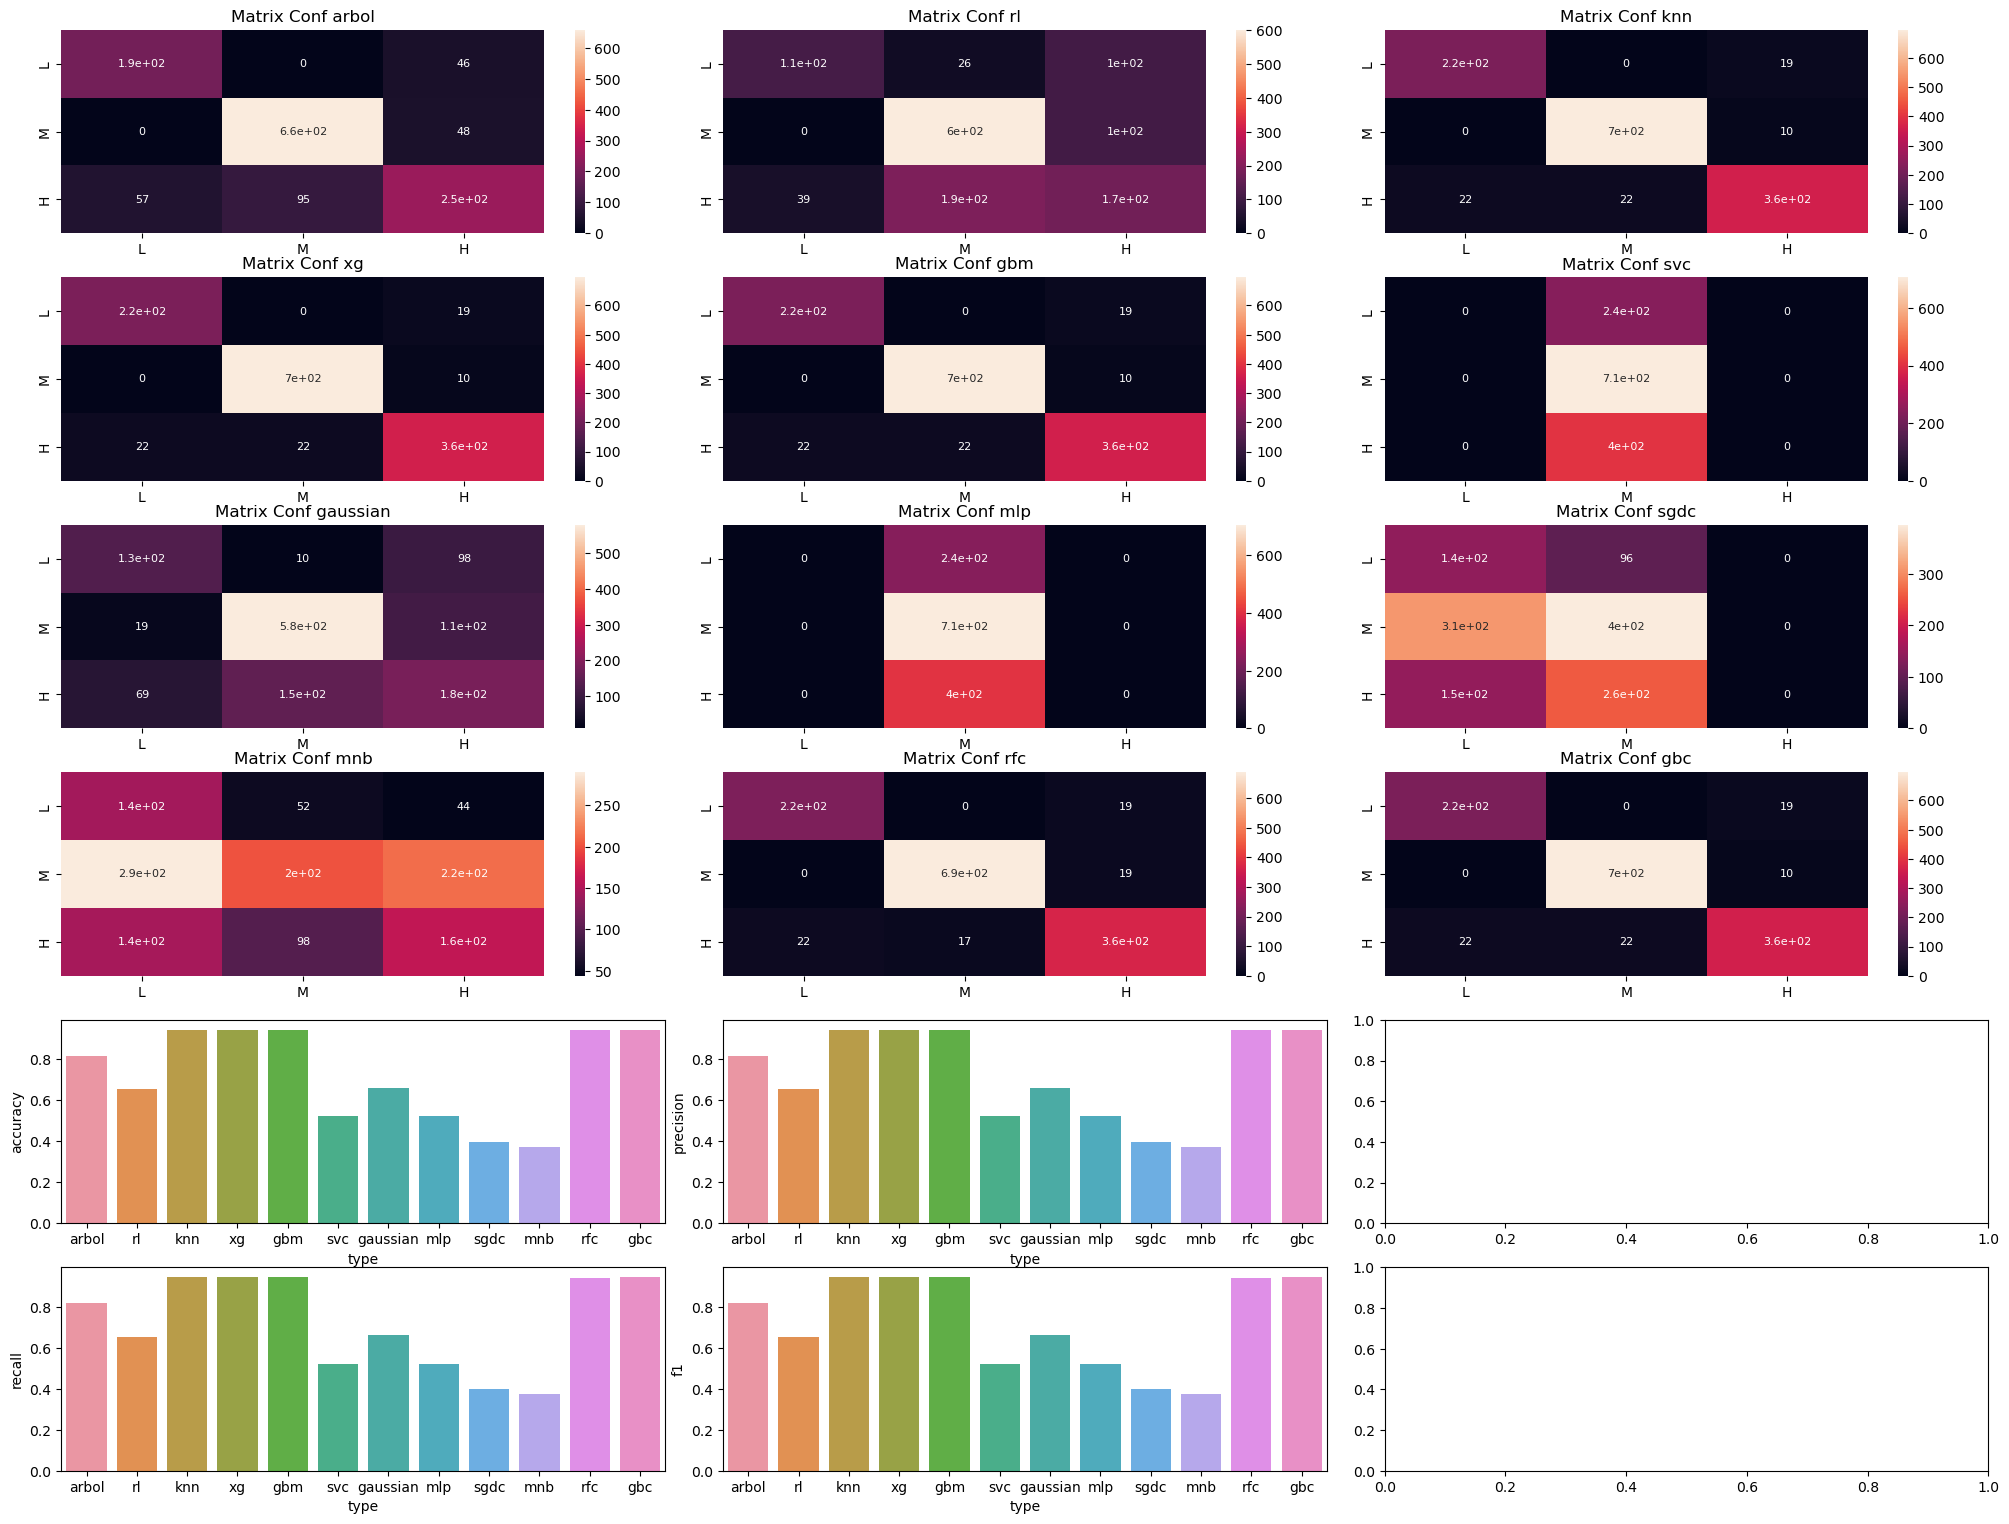

In [20]:
#Modelando para Caudal Bruto
df1 = df.copy(deep=True)
lista_de_variables_x = ['XCOORD', 'YCOORD', 'Prof','Dpiston']
df1['bbpd_group'] = label_encoder.fit_transform(df1['bbpd_group'])

resumen = pd.DataFrame(columns=['type','accuracy','precision','recall','f1'])
options = ['arbol','rl','knn','xg','gbm','svc','gaussian','mlp','sgdc','mnb','rfc','gbc']
columns = 3

fig, axes = plt.subplots(6,columns, figsize=(20,15))
fig.tight_layout()

for i,t in enumerate(options):
    accuracy,precision,recall,f1,cm = calcular_modelo(lista_de_variables_x,'bbpd_group',df1,False,t,10)
    r = int(i/columns)
    l = i-(columns*r)
    _= sns.heatmap(ax=axes[r , l],data=cm,annot=True, xticklabels=['L','M','H'],yticklabels=['L','M','H'],annot_kws={"size": 8})
    _=axes[r,l].set_title('Matrix Conf ' + t)
    resumen = resumen.append({'type':t,'accuracy':accuracy,'precision':precision,'recall':recall,'f1':f1},ignore_index=True)

_= sns.barplot(ax=axes[4,0],data=resumen,y='accuracy',x='type')
_= sns.barplot(ax=axes[4,1],data=resumen,y='precision',x='type')
_= sns.barplot(ax=axes[5,0],data=resumen,y='recall',x='type')
_= sns.barplot(ax=axes[5,1],data=resumen,y='f1',x='type')

In [21]:
# Halving Randomized Search XGB
modelxgb= xgb.XGBClassifier(learning_rate=0.001)

df2 = df.copy(deep=True)
lista_de_variables_x = ['XCOORD', 'YCOORD', 'Prof','Dpiston']
df2['bbpd_group'] = label_encoder.fit_transform(df2['bbpd_group'])

X = df2[lista_de_variables_x]
y = df2['bbpd_group'].astype(int) 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=5)

params_grid = {'min_child_weight': [1, 5, 10],'gamma': [0.5, 1, 1.5, 2, 5],'subsample': [0.6, 0.8, 1.0],'colsample_bytree': [0.6, 0.8, 1.0],'max_depth': [5,6,7]}
_ = halving_cv = HalvingRandomSearchCV(modelxgb, params_grid, scoring="accuracy", factor=3)
_ = halving_cv.fit(X_train, y_train)

print("Mejores parametros", halving_cv.best_params_)
print("Mejor CV score", halving_cv.best_score_)
print(f'Accuracy del modelo = {round(accuracy_score(y_test, halving_cv.predict(X_test)), 5)}')



Mejores parametros {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 6, 'gamma': 2, 'colsample_bytree': 0.6}
Mejor CV score 0.9374485596707819
Accuracy del modelo = 0.9318


6).-¿Es posible clasificar un pozo nuevo como alto, medio o bajo productor y que método es el que resulta más apropiado para modelarlo?

Con relativa buena precision (>94%) es posible clasificar un pozo nuevo como alto, medio o bajo productor basado en condición espaciales y la velocidad de operación, los métodos más acertados son 'KNeighborsClassifier', 'XGBClassifier' y 'LGBMClassifier', resulta relevante como basado en matriz de confusion vemos como 'KNeighborsClassifier', 'XGBClassifier' y 'LGBMClassifier' se comportan de una forma casi identica, resaltan 19 casos de error criticos donde los pozos son clasificados como alto caudal y resultarian siendo de bajo y 10 de moderado cuidado donde son clasificado como altos pero son bajos, aunque en promedio estos 29 casos de cuidado tienen un contrapeso de 44 pozos que serian clasificados como bajo o medio y en realidad serian altos potencial.

**AyS**

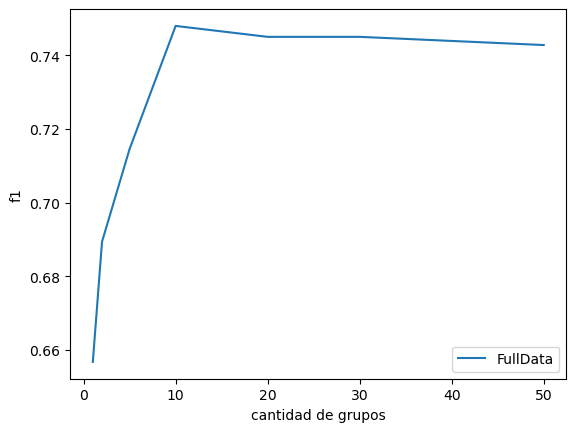

In [22]:
#Escogiendo la cantidad de vecinos con el knn

df1 = df
df1['ays_group_auto']=pd.qcut(df1['AYS'],3)
lista_de_variables_x = ['XCOORD', 'YCOORD', 'Prof','Dpiston']
# print(df1['ays_group_auto'].unique())
label_encoder = LabelEncoder()
df1['ays_group_auto'] = label_encoder.fit_transform(df1['ays_group_auto'])

resumen_k = pd.DataFrame(columns=['cantidad de grupos','f1'])

for i in [1,2,5,10,20,30,50]:
    accuracy,precision,recall,f1,cm = calcular_modelo(lista_de_variables_x,'ays_group_auto',df1,False,'knn',i)
    resumen_k = resumen_k.append({'cantidad de grupos':i,'f1':f1},ignore_index=True)

_= sns.lineplot(data=resumen_k,x="cantidad de grupos",y="f1",label="FullData")

En base a la cantidad de grupos para el método de knn se observa como con 10 

1.   Elemento de lista
2.   Elemento de lista

grupos se obtienen los mejores resultados.

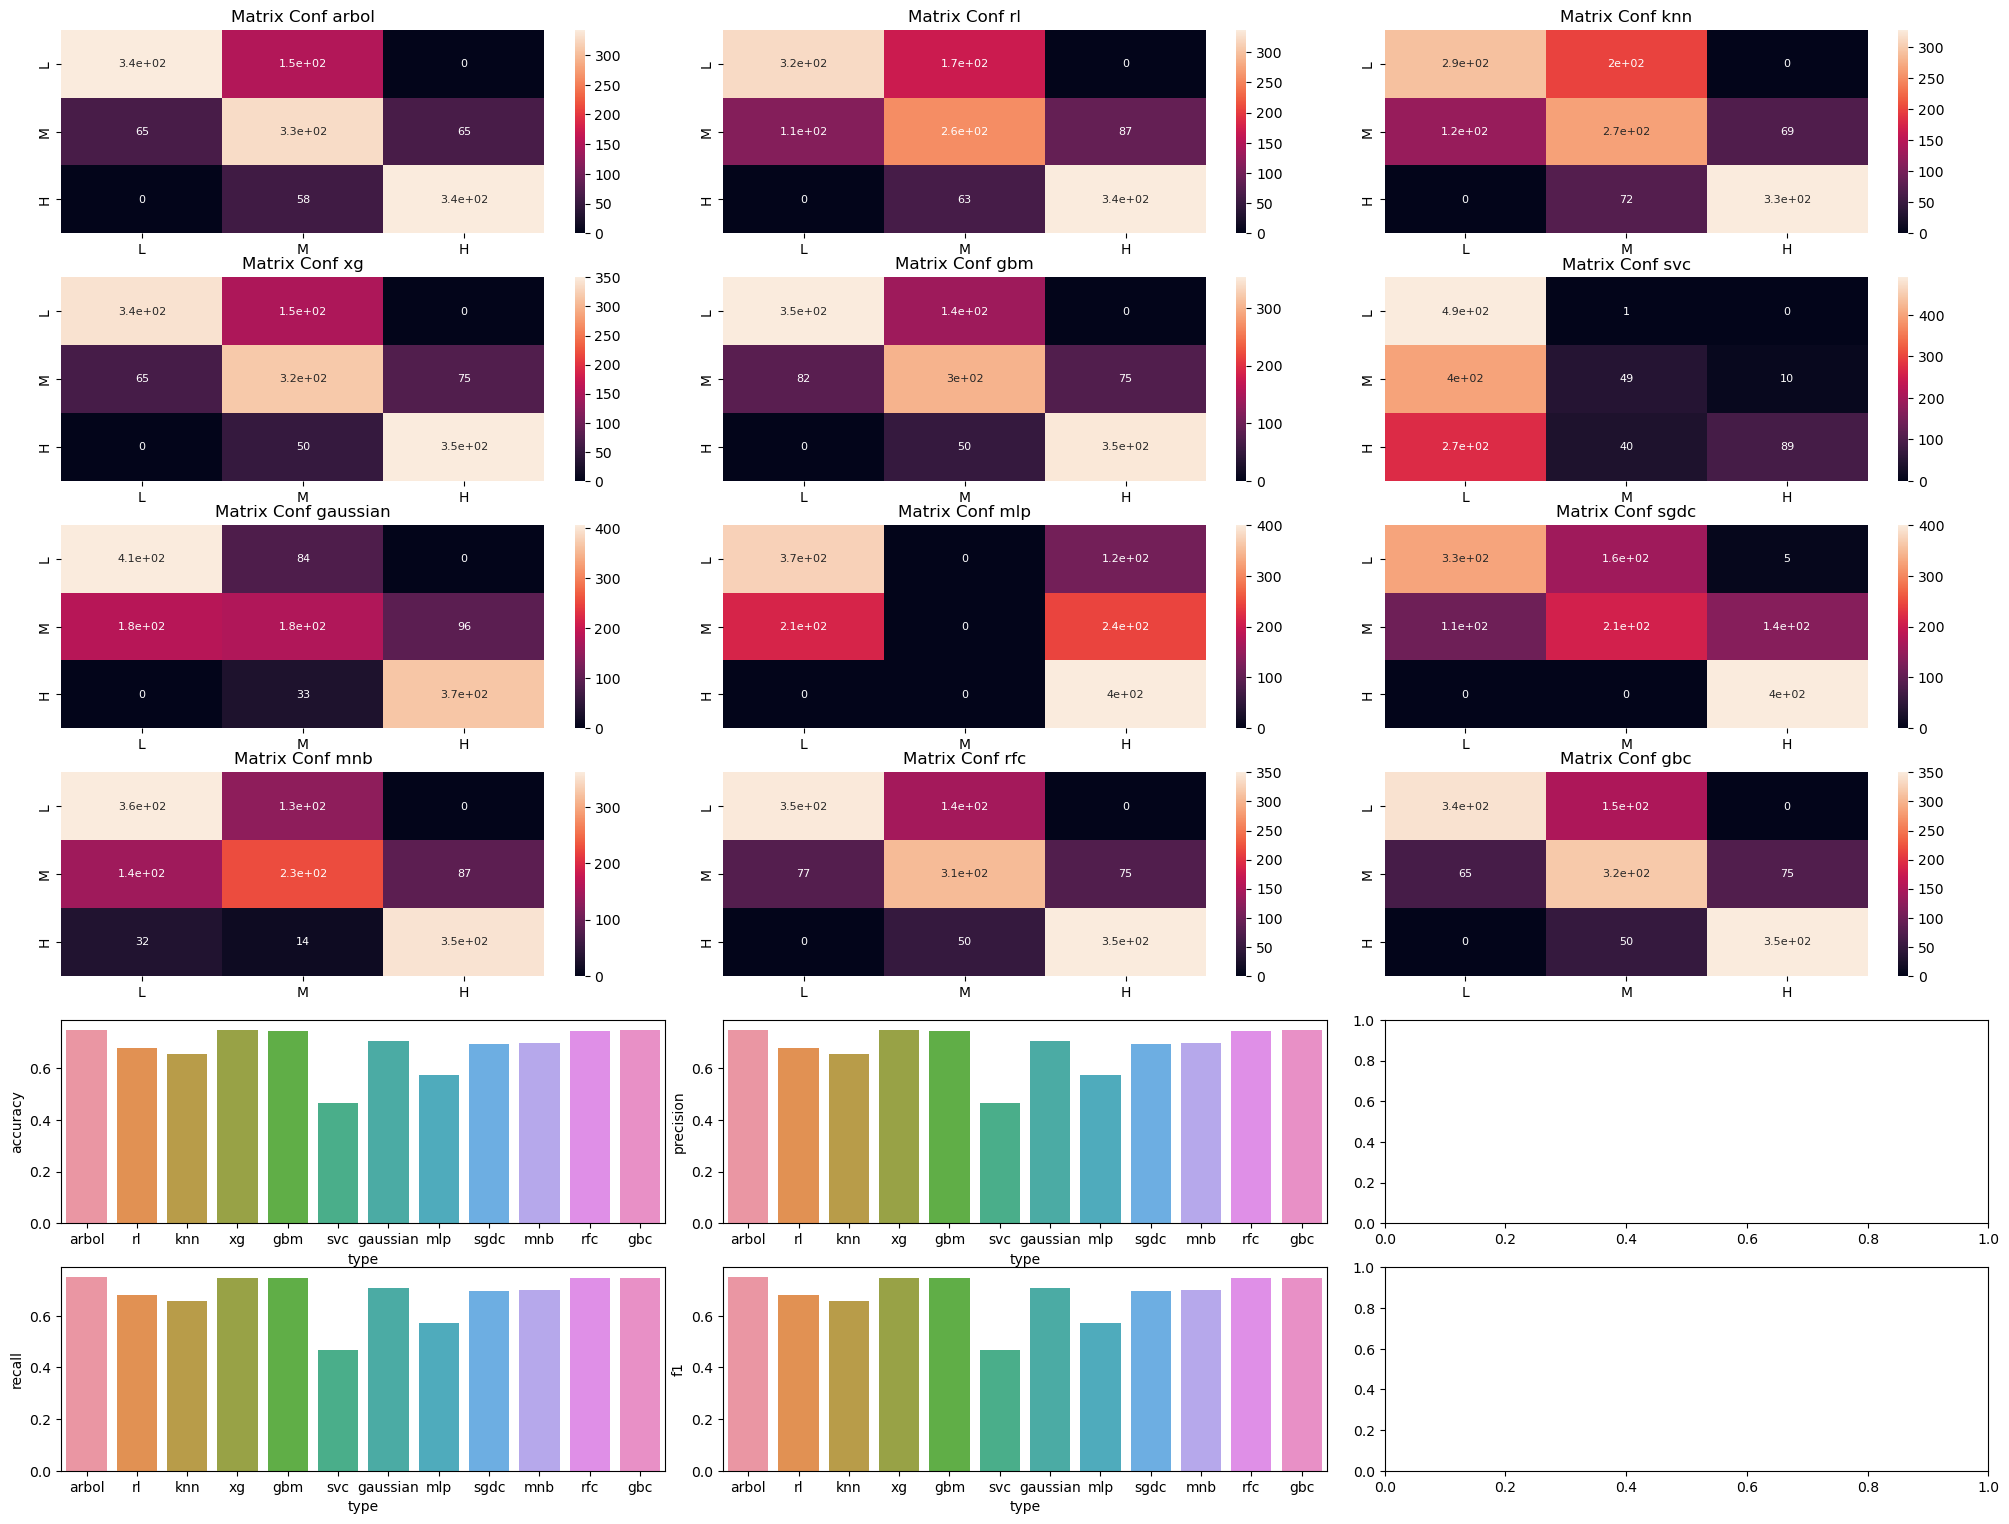

In [23]:
#Modelando para AyS
df1 = df.copy(deep=True)
df1['ays_group_auto']=pd.qcut(df1['AYS'],3)
lista_de_variables_x = ['XCOORD', 'YCOORD', 'Prof','Dpiston']
# print(df1['ays_group_auto'].unique())

label_encoder = LabelEncoder()
df1['ays_group_auto'] = label_encoder.fit_transform(df1['ays_group_auto'])

resumen = pd.DataFrame(columns=['type','accuracy','precision','recall','f1'])
options = ['arbol','rl','knn','xg','gbm','svc','gaussian','mlp','sgdc','mnb','rfc','gbc']
columns = 3

fig, axes = plt.subplots(6,columns, figsize=(20,15))
fig.tight_layout()

for i,t in enumerate(options):
    accuracy,precision,recall,f1,cm = calcular_modelo(lista_de_variables_x,'ays_group_auto',df1,False,t)
    r = int(i/columns)
    l = i-(columns*r)
    _= sns.heatmap(ax=axes[r,l],data=cm,annot=True, xticklabels=['L','M','H'],yticklabels=['L','M','H'],annot_kws={"size": 8})
    _=axes[r,l].set_title('Matrix Conf ' + t)
    resumen = resumen.append({'type':t,'accuracy':accuracy,'precision':precision,'recall':recall,'f1':f1},ignore_index=True)


_= sns.barplot(ax=axes[4,0],data=resumen,y='accuracy',x='type')
_= sns.barplot(ax=axes[4,1],data=resumen,y='precision',x='type')
_= sns.barplot(ax=axes[5,0],data=resumen,y='recall',x='type')
_= sns.barplot(ax=axes[5,1],data=resumen,y='f1',x='type')

In [24]:
# Halving Randomized Search XGB
modelxgb= xgb.XGBClassifier(learning_rate=0.001)

df3 = df.copy(deep=True)
df3['ays_group_auto']=pd.qcut(df3['AYS'],3)
lista_de_variables_x = ['XCOORD', 'YCOORD', 'Prof','Dpiston']
df3['ays_group_auto'] = label_encoder.fit_transform(df3['ays_group_auto'])

X = df3[lista_de_variables_x]
y = df3['ays_group_auto'].astype(int) 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=5)

params_grid = {'min_child_weight': [1, 5, 10],'gamma': [0.5, 1, 1.5, 2, 5],'subsample': [0.6, 0.8, 1.0],'colsample_bytree': [0.6, 0.8, 1.0],'max_depth': [5,6,7]}
_ = halving_cv = HalvingRandomSearchCV(modelxgb, params_grid, scoring="accuracy", factor=3)
_ = halving_cv.fit(X_train, y_train)

print("Mejores parametros", halving_cv.best_params_)
print("Mejor CV score", halving_cv.best_score_)
print(f'Accuracy del modelo = {round(accuracy_score(y_test, halving_cv.predict(X_test)), 5)}')

Mejores parametros {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 6, 'gamma': 2, 'colsample_bytree': 0.8}
Mejor CV score 0.7646090534979424
Accuracy del modelo = 0.7487


7).-¿Es posible clasificar un pozo nuevo como alto, medio o bajo corte de agua y que método es el que resulta más apropiado para modelarlo?

Con relativa media precisión (~>74%) (usando Randomized Search XGB ) es posible clasificar un pozo nuevo como alto, medio o bajo productor con base en condiciones espaciales y la velocidad de operación, el método más acertado es 'XGB', Es relevante como basados en matriz de confusion, en el caso de AYS el 'KNeighborsClassifier' tiende a subestimar en 1200 casos el corte de agua, clasificandolo como bajo pero que en realidad seria de medio caudal de AYS y en contraposicon en 200 casos hace lo inverso clasifica como medio y seria bajo caudal de AyS, este parametro es critico y se recomienda descartar este algortimo y quedarse solo con XG y GBM para clasificar por producto de AYS.


**======================================================Final Clustering Model===================================================**

In [25]:

# traing the clustering final models for BBPD
df4 = df.copy(deep=True)
lista_de_variables_x = ['XCOORD', 'YCOORD', 'Prof','Dpiston']
df4['bbpd_group'] = label_encoder.fit_transform(df4['bbpd_group'])
Xcbbpd = df4[lista_de_variables_x]
ycbbpd = df4['bbpd_group'].astype(int) 
X_train_cbbpd, X_test_cbbpd, y_train_cbbpd, y_test_cbbpd = train_test_split(Xcbbpd,ycbbpd,test_size=0.3, random_state=5)
clf = xgb.XGBClassifier(learning_rate=0.001,subsample=1,min_child_weight=1,max_depth=7,gamma=1.5,colsample_bytree=0.6)
cluster_model_bbpd = clf.fit(X_train_cbbpd,y_train_cbbpd)


# traing the clustering final models for BBPD
df5 = df.copy(deep=True)
df5['ays_group_auto']=pd.qcut(df5['AYS'],3)
lista_de_variables_x = ['XCOORD', 'YCOORD', 'Prof','Dpiston']
df5['ays_group_auto'] = label_encoder.fit_transform(df5['ays_group_auto'])
Xcays = df5[lista_de_variables_x]
ycays = df5['ays_group_auto'].astype(int) 
X_train_cays, X_test_cays, y_train_cays, y_test_cays = train_test_split(Xcays,ycays,test_size=0.3, random_state=5)
clf = xgb.XGBClassifier(learning_rate=0.001,subsample=1,min_child_weight=1,max_depth=7,gamma=1.5,colsample_bytree=0.6)
cluster_model_asyc = clf.fit(X_train_cays,y_train_cays)



**======================================================Data Regretion===================================================**

In [26]:
#Funcion de calculo de las regresiones

def calcular_regresion(lista_de_variables_x,target,data,show_summary=True, modelo='linear', retunrModel=False):
    X = data[lista_de_variables_x]
    y = data[target].astype(int) 
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=5)
   
    if (modelo=='linear'):
        model = LinearRegression()

    if (modelo=='gbm'):
        model = ltb.LGBMRegressor()

    if (modelo=='ridge'):
        model = Ridge(alpha=0.5)

    if (modelo=='lasso'):
        model = Lasso(alpha=0.2, fit_intercept=True, normalize=False, precompute=False, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')

    if (modelo=='rfr'):
        model = rfr(n_estimators = 100, criterion = 'mse', random_state = 1, n_jobs = -1)

    model.fit(X_train, y_train)
    y_pred_rl = model.predict(X_test)

    summary = pd.DataFrame({'X_test':X_test['XCOORD'],'y_test':y_test,'Actual': y_test, 'Predicted': y_pred_rl})
    summary['AE'] = abs(summary['Actual']-summary['Predicted'])
    # average = sum(summary['AE']/summary['AE'].count())

    resTab = {
        'X_train':X_train,
        'X_test':X_test,
        'y_train':y_train,
        'y_test':y_test,
        'summary':summary
    }
    
    MAE = metrics.mean_absolute_error(y_test, y_pred_rl)
    MSE = metrics.mean_squared_error(y_test, y_pred_rl)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rl))

    if(retunrModel):
        return model

    if (show_summary):
        print(f"MAE : {MAE} , MSE {MSE} , RMSE: {RMSE} ")

    return MAE, MSE, RMSE, resTab


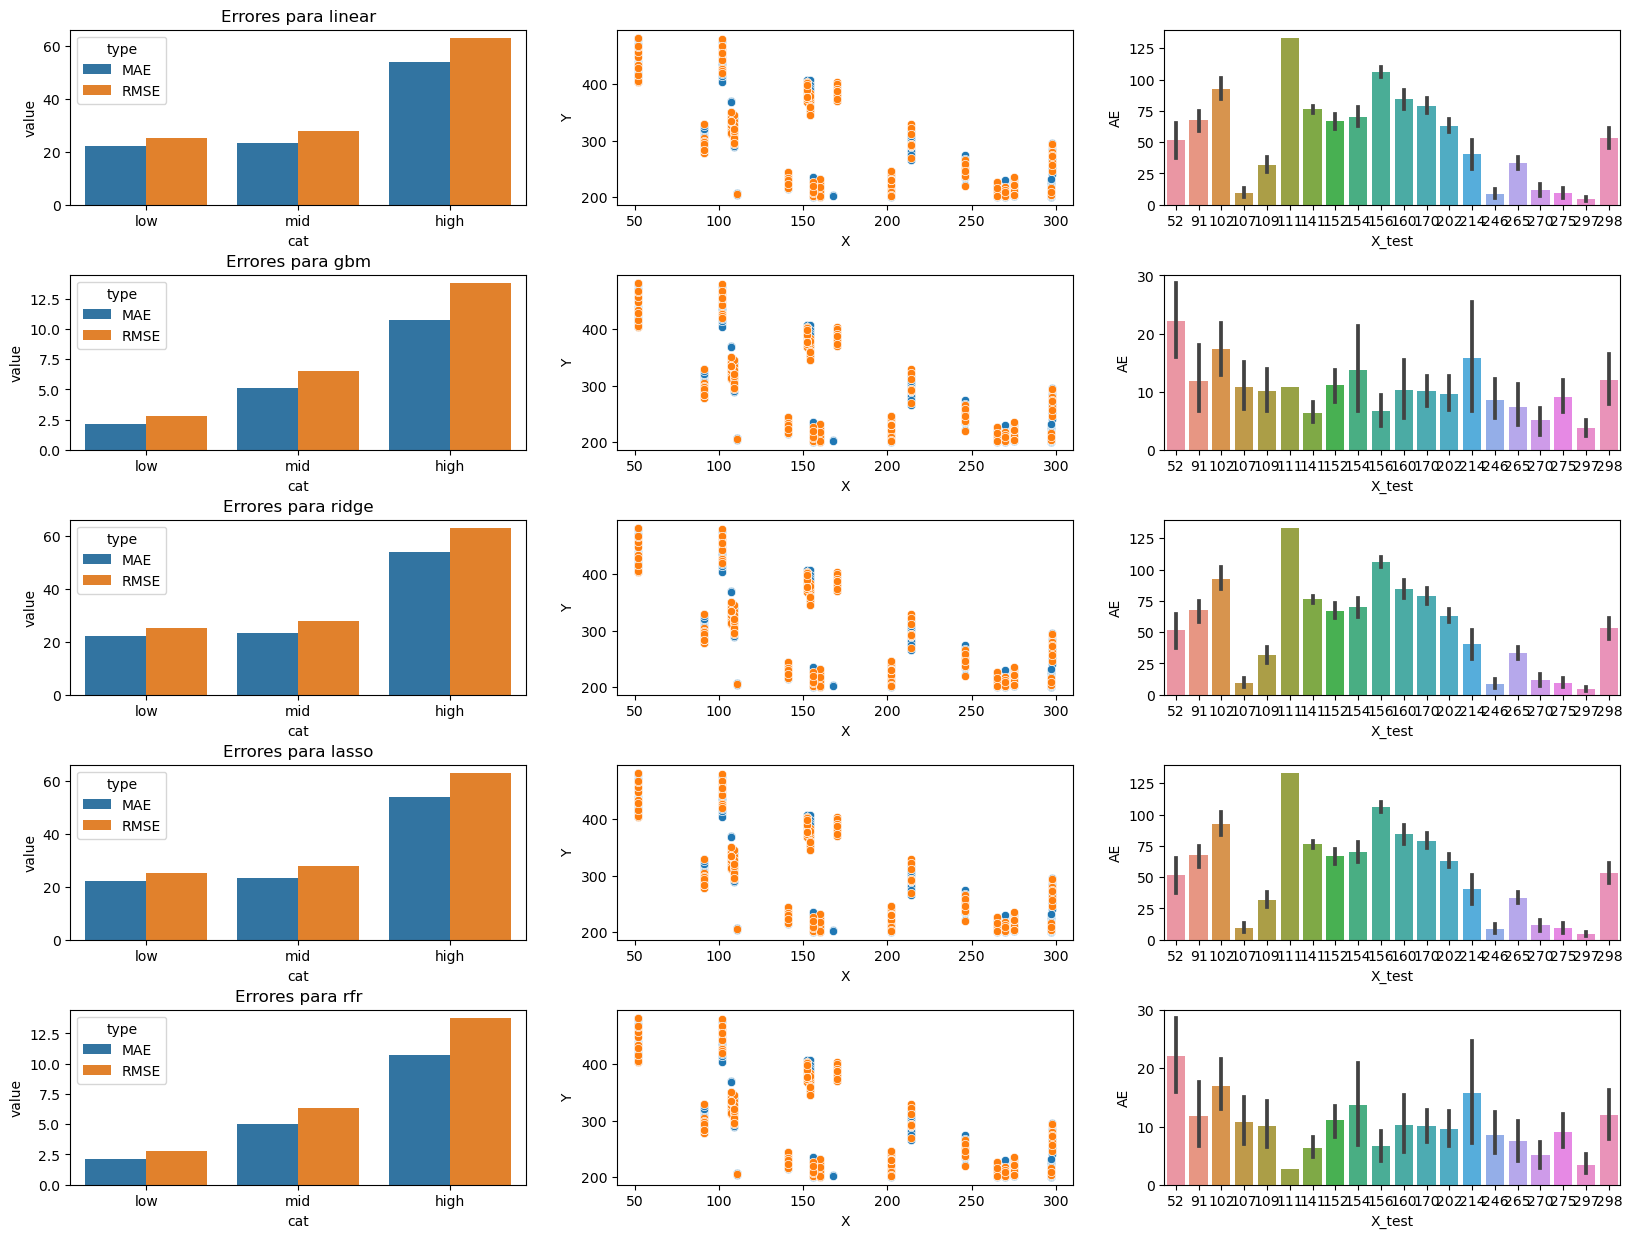

In [27]:
#Calculando para Caudal Bruto

lista_de_variables_x = ['Prof','XCOORD','YCOORD']
options = ['linear','gbm','ridge','lasso','rfr']

fig, axes = plt.subplots(5,3, figsize=(20,15))
fig.subplots_adjust(hspace=0.4)

for i,t in enumerate(options):
    resumen = pd.DataFrame(columns=['cat','met','type','value'])
    for q in ['low','mid','high']: 
        df1 = df[df['bbpd_group']==q]
        MAE, MSE, RMSE, resTab = calcular_regresion(lista_de_variables_x,'BBPD',df1,False,t)
        resumen = resumen.append({'cat':q,'met':t,'type':'MAE','value':MAE},ignore_index=True)
        resumen = resumen.append({'cat':q,'met':t,'type':'RMSE','value':RMSE},ignore_index=True)
    
    _=axes[i,0].set_title('Errores para ' + t)
    _ = sns.barplot(ax=axes[i,0],data=resumen,y='value',x='cat',hue='type')
    _ = sns.scatterplot(ax=axes[i,1],data=pd.DataFrame({'X':resTab['X_train']['XCOORD'],'Y':resTab['y_train']}),x='X',y='Y')
    _ = sns.scatterplot(ax=axes[i,1],data=pd.DataFrame({'X':resTab['X_test']['XCOORD'],'Y':resTab['y_test']}),x='X',y='Y')
    _ = sns.barplot(ax=axes[i,2],data=resTab["summary"],x='X_test',y='AE')


8).-¿Es posible predecir la tasa de producción bruta de un pozo nuevo y qué método resulta más aporpiado?

La tasa final de un pozo será un parámetro multifactorial pero con base en una clasificación inicial que permite evaluar inversión económica si se podría predecir un valor aproximado de la tasa de crudo, siempre que el pozo pueda ser previamente clasificado como alto, bajo o medio productor, el valor obtenido tendría una variación de: 
    
    * ~ +/- 3 bbpd para pozos de baja tasa
    * ~ +/- 5 bbpd para pozos de media tasa
    * ~ +/- 11 bbpd para pozos de alta tasa

Esto utilizando el método de LGBMRegressor.


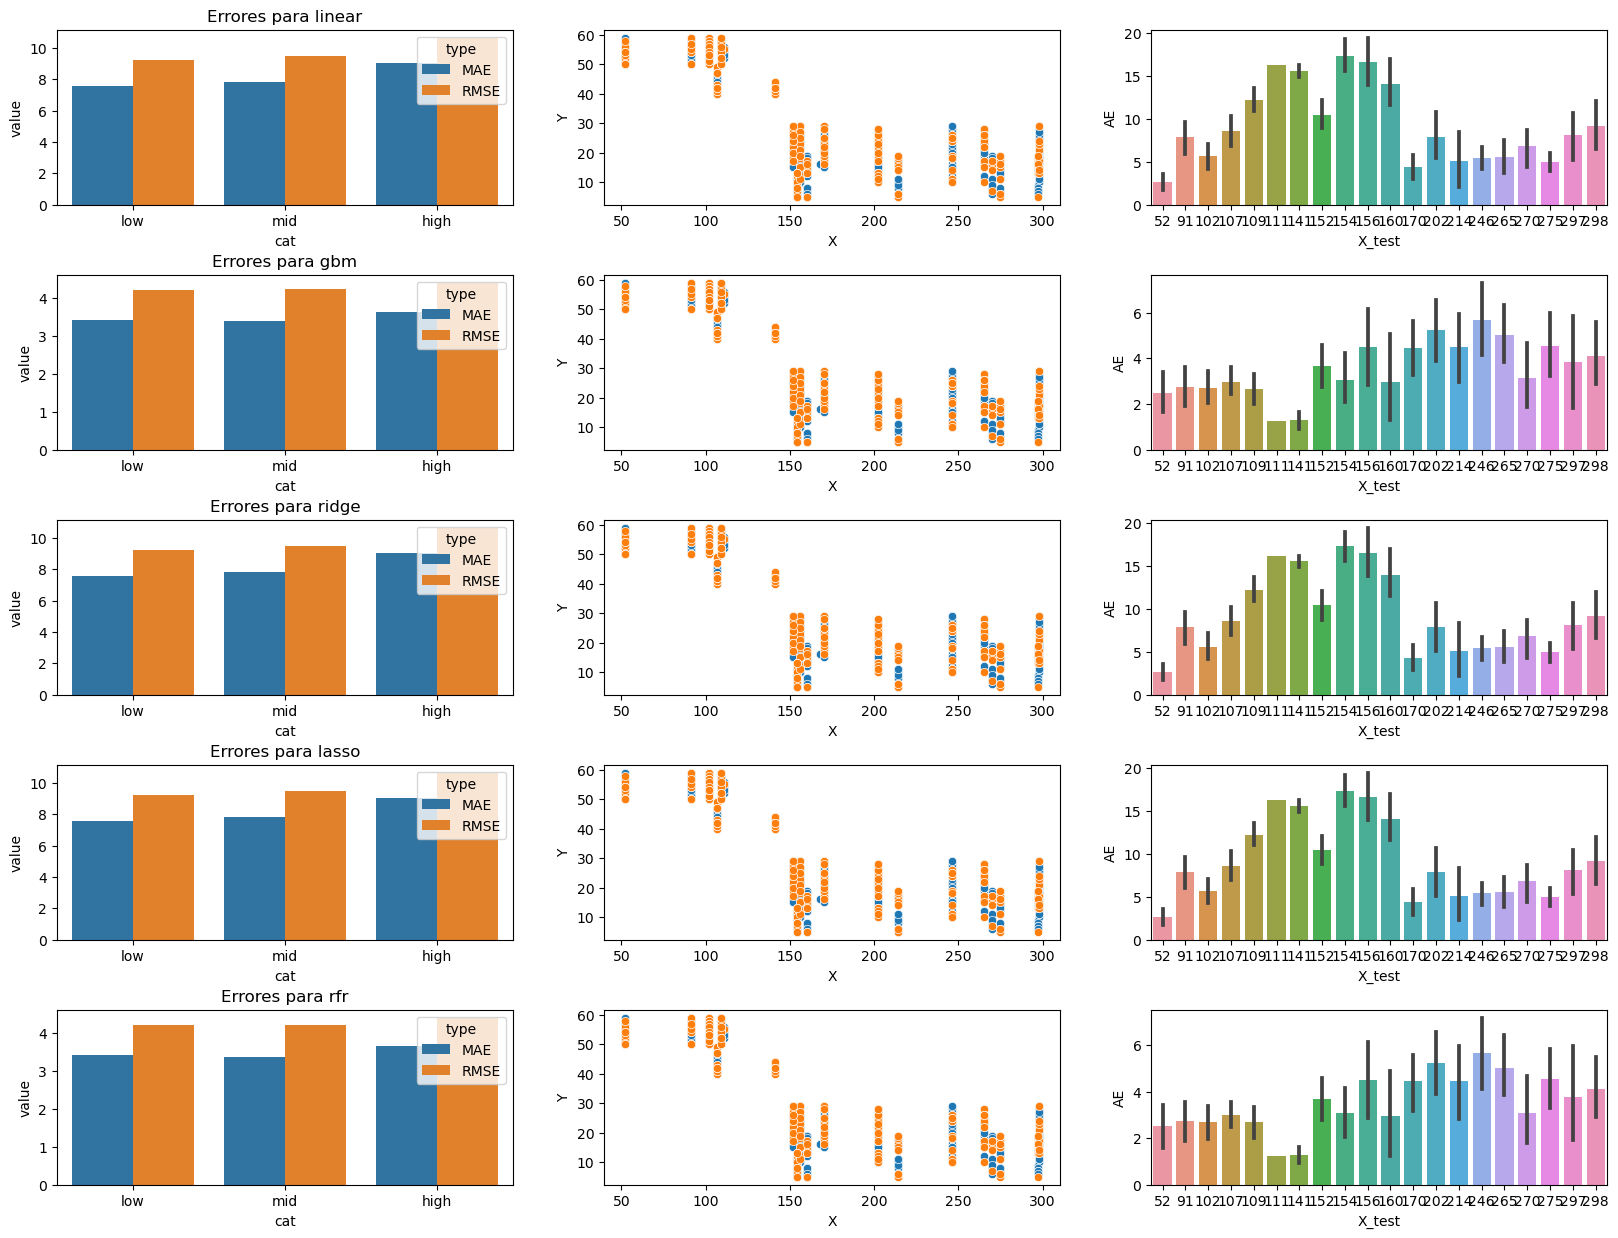

In [28]:
#Calculando AyS

lista_de_variables_x = ['Prof','XCOORD','YCOORD']
resumen = pd.DataFrame(columns=['cat','type','MAE','MSE','RMSE'])
options = ['linear','gbm','ridge','lasso','rfr']

fig, axes = plt.subplots(5,3, figsize=(20,15))
fig.subplots_adjust(hspace=0.4)

for i,t in enumerate(options):
    resumen = pd.DataFrame(columns=['cat','met','type','value'])
    for q in ['low','mid','high']: 
        df1 = df[df['bbpd_group']==q]
        MAE, MSE, RMSE, resTab = calcular_regresion(lista_de_variables_x,'AYS',df1,False,t)
        resumen = resumen.append({'cat':q,'met':t,'type':'MAE','value':MAE},ignore_index=True)
        resumen = resumen.append({'cat':q,'met':t,'type':'RMSE','value':RMSE},ignore_index=True)
    
    _=axes[i,0].set_title('Errores para ' + t)
    _ = sns.barplot(ax=axes[i,0],data=resumen,y='value',x='cat',hue='type')
    _ = sns.scatterplot(ax=axes[i,1],data=pd.DataFrame({'X':resTab['X_train']['XCOORD'],'Y':resTab['y_train']}),x='X',y='Y')
    _ = sns.scatterplot(ax=axes[i,1],data=pd.DataFrame({'X':resTab['X_test']['XCOORD'],'Y':resTab['y_test']}),x='X',y='Y')
    _ = sns.barplot(ax=axes[i,2],data=resTab["summary"],x='X_test',y='AE')


9).-¿Es posible predecir la tasa de agua de un pozo nuevo y que método resulta más apropiado?

La tasa final de agua de un pozo será un parámetro multifactorial pero con base en una clasificacion inicial que permite evaluar inversión económica si se podría predecir un valor aproximado de la tasa de crudo, siempre que el pozo pueda ser previamente clasificado como alto, bajo o medio productor, el valor obtenido tendría una variación de: 
    
    * ~ +/- 4 para pozos de alto, baja y media tasa

Esto utilizando el método de LGBMRegressor.

**======================================================Final Regresion Model===================================================**

In [29]:
# traing the regresion final models for BBPD
lista_de_variables_x = ['Prof','XCOORD','YCOORD']
df6 = df.copy(deep=True)
df6l = df[df['bbpd_group']=='low']
df6m = df[df['bbpd_group']=='mid']
df6h = df[df['bbpd_group']=='high']

model_rbbpd_low = calcular_regresion(lista_de_variables_x,'BBPD',df6l,False,'rfr',True)
model_rbbpd_mid = calcular_regresion(lista_de_variables_x,'BBPD',df6m,False,'rfr',True)
model_rbbpd_high = calcular_regresion(lista_de_variables_x,'BBPD',df6h,False,'rfr',True)


# traing the regresion final models for BBPD
lista_de_variables_x = ['Prof','XCOORD','YCOORD']
df7 = df.copy(deep=True)
df7l = df[df['bbpd_group']=='low']
df7m = df[df['bbpd_group']=='mid']
df7h = df[df['bbpd_group']=='high']

model_rays_low = calcular_regresion(lista_de_variables_x,'AYS',df7l,False,'rfr',True)
model_rays_mid = calcular_regresion(lista_de_variables_x,'AYS',df7m,False,'rfr',True)
model_rays_high = calcular_regresion(lista_de_variables_x,'AYS',df7h,False,'rfr',True)



**========================= Model Export ======================================**

In [30]:
export_model_bbpd_clustering = open('models/cluster_model_bbpd.pkl',"wb")
pickle.dump(cluster_model_bbpd,export_model_bbpd_clustering)
export_model_bbpd_clustering.close()


export_model_ays_clustering = open('models/cluster_model_asyc.pkl',"wb")
pickle.dump(cluster_model_asyc,export_model_ays_clustering)
export_model_ays_clustering.close()


export_model_rbbpd_low = open('models/model_rbbpd_low.pkl',"wb")
pickle.dump(model_rbbpd_low,export_model_rbbpd_low)
export_model_rbbpd_low.close()

export_model_rbbpd_mid = open('models/model_rbbpd_mid.pkl',"wb")
pickle.dump(model_rbbpd_mid,export_model_rbbpd_mid)
export_model_rbbpd_mid.close()

export_model_rbbpd_high = open('models/model_rbbpd_high.pkl',"wb")
pickle.dump(model_rbbpd_high,export_model_rbbpd_high)
export_model_rbbpd_high.close()

export_model_rays_low = open('models/model_rays_low.pkl',"wb")
pickle.dump(model_rays_low,export_model_rays_low)
export_model_rays_low.close()

export_model_rays_mid = open('models/model_rays_mid.pkl',"wb")
pickle.dump(model_rays_mid,export_model_rays_mid)
export_model_rays_mid.close()

export_model_rays_high = open('models/model_rays_high.pkl',"wb")
pickle.dump(model_rays_high,export_model_rays_high)
export_model_rays_high.close()
